# Libraries

In [1]:
# Standard Libraries
from collections import namedtuple
from dataclasses import dataclass, field
from datetime import datetime, date, time
from pprint import pprint
from typing import List, Any
import pickle
import os

# Data Management
import numpy as np
import pandas as pd

# Stats and Optimization
from scipy import stats
from scipy.optimize import minimize_scalar
from scipy.integrate import simpson

# Solar Position Calculation
from pvlib import solarposition

# Graphing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Intel Sklearn CPU Acceleration
# The following 2 lines must come before any sklearn imported modules: https://uxlfoundation.github.io/scikit-learn-intelex/latest/quick-start.html
from sklearnex import patch_sklearn
patch_sklearn()

# Modelling
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection._base import SelectorMixin
from sklearn.feature_selection import (RFECV, RFE, SelectFromModel, SelectKBest,
                                       f_classif, f_regression, mutual_info_regression,
                                       VarianceThreshold)
from sklearn.model_selection import (KFold, RandomizedSearchCV, TimeSeriesSplit,
                                     cross_val_score, permutation_test_score,
                                     train_test_split)
from sklearn.metrics import (mean_absolute_error, mean_absolute_percentage_error,
                             mean_squared_error, make_scorer, r2_score,
                             root_mean_squared_error)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, PowerTransformer, QuantileTransformer,
                                   StandardScaler)
from sklearn.tree import plot_tree

# Baseline Correction
from pybaselines.utils import whittaker_smooth

# Filtering
from filterpy.kalman import KalmanFilter

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


# Data Import

**Functions**

In [ ]:
coordinates = namedtuple("coordinates", ["lat", "lon"])

@dataclass
class class_data:
    flux: pd.DataFrame
    satellite: pd.DataFrame
    paired: pd.DataFrame
    training: pd.DataFrame
    stats: dict
    coords: coordinates

# Convert unix timestamps to datetimes
def convert_unixtime(df, column, format = None, unit = None, new_name = "datetime"):
    df[new_name] = pd.to_datetime(df[column], format = format, unit = unit)

# Clean data
def cleaner(df, variable_name):
    df[variable_name] = df[variable_name].replace([-9999.0], np.nan) # Replace visible/known missing values
    df = df.reindex(pd.date_range(start = df.index[0], end = df.index[-1], freq = "30min")) # Reindex to deal with hidden missing values
    #df.index.name = "date" # put the name of the index column back!
    df = df[[variable_name]].copy()
    return df

def calc_time_by_solar(latitude, longitude, date, target_elevation, target_azimuth):
    # Minimize the difference in solar position
    def objective(mins_since_midnight):
        dt = date + pd.Timedelta(minutes = mins_since_midnight)
        pos = solarposition.get_solarposition(dt, latitude, longitude)
        elev = pos["apparent_elevation"].values[0]
        azim = pos["azimuth"].values[0]
        return (elev - target_elevation)**2 + (azim - target_azimuth)**2
    
    # Optimize over a 24-hour period
    res = minimize_scalar(objective, bounds = (0, 1440), method = "bounded") # using 1440 for number of mins in 24 hours. Don"t need more resolution than this
    return date + pd.Timedelta(minutes = res.x) # Get the time of day (res.x) and add it to the input date.

# Change Annoying MODIS azimuth from -180-180 to 0-360
# replace if with modulo also no for loop
def normalise_azimuth(df, column):
    for idx, azimuth in enumerate(df[column]):
        # If azimuth is less than 0, add 360 to make it in the 0 to 360 range.
        if azimuth < 0:
            df.at[idx, column] = azimuth + 360

**Import**

In [ ]:
flux_cols = [
    "TIMESTAMP_END",
    "GPP_DT_VUT_REF", # gross primary production
    "WD", # wind direction (decimal degrees)
    #"SWC_F_MDS_1", # soil water content at depth 1, gap-filled with MDS
    #"SWC_F_MDS_2", # soil water content at depth 2, gap-filled with MDS
    ]

data = { 
    "se_st1": class_data(
        flux = pd.read_csv(
            "../data/raw/flux/abisko-stordalen-grassland/FLX_SE-St1_FLUXNET2015_FULLSET_HH_2012-2019_beta-3.csv", 
            usecols = flux_cols
        ),
        satellite = pd.read_csv("../data/raw/satellite/tundra-flux_abisko-stordalen-grassland_glcm.csv"),
        paired = pd.DataFrame(),
        training = pd.DataFrame(),
        stats = {},
        coords = coordinates(68.35415, 19.050333),
    ),
    "se_sto": class_data(
        flux = pd.read_csv(
            "../data/raw/flux/abisko-stordalen-palsa-bog/ICOSETC_SE-Sto_FLUXNET_HH_L2.csv", 
            usecols = flux_cols
        ),
        satellite = pd.read_csv("../data/raw/satellite/tundra-flux_abisko-stordalen-palsa-bog_glcm.csv"),
        paired = pd.DataFrame(),
        training = pd.DataFrame(),
        stats = {},
        coords = coordinates(68.35594288, 19.04520892),
    ),
    "fi_ken": class_data(
        flux = pd.read_csv(
            "../data/raw/flux/kenttarova/ICOSETC_FI-Ken_FLUXNET_HH_L2.csv",
            usecols = flux_cols
        ),
        satellite = pd.read_csv("../data/raw/satellite/tundra-flux_kenttarova_glcm.csv"),
        paired = pd.DataFrame(),
        training = pd.DataFrame(),
        stats = {},
        coords = coordinates(67.98721, 24.24301),
    ),
    "fi_sod": class_data(
        flux = pd.read_csv(
            "../data/raw/flux/sodankyla/ICOSETC_FI-Sod_FLUXNET_HH_L2.csv",
            usecols = flux_cols
        ),
        satellite = pd.read_csv("../data/raw/satellite/tundra-flux_sodankyla_glcm.csv"),
        paired = pd.DataFrame(),
        training = pd.DataFrame(),
        stats = {},
        coords = coordinates(67.36239, 26.63859),
    ),
    "fi_var": class_data(
        flux = pd.read_csv(
            "../data/raw/flux/varrio/ICOSETC_FI-Var_FLUXNET_HH_L2.csv",
            usecols = flux_cols
        ),
        satellite = pd.read_csv("../data/raw/satellite/tundra-flux_varrio_glcm.csv"),
        paired = pd.DataFrame(),
        training = pd.DataFrame(),
        stats = {},
        coords = coordinates(67.7549, 29.61),
    )
}

## Pre-processing

Clean data and make it uniform.

**Flux Tower**

Note: For the st1 site, it sits on the boundary between two ecosystems; a shallow-lake and a fen-type wetland. As per the site info (https://meta.icos-cp.eu/resources/stations/ES_SE-St1), "*Fluxes come from one or the other ecosystem depending on wind direction. The wind flow regularly switches between two main directions. Suggestion to separate sectors: 20N-135N is full lake; 210N-330N is full fen.*"

In [ ]:
for key, item in data.items():
    
    # Rename Columns
    item.flux = item.flux.rename(columns = {
        "TIMESTAMP_END": "unixtime",
        "GPP_DT_VUT_REF": "gpp",
        "WD": "wind_direction",
        "SWC_F_MDS_1": "swc_1",
        "SWC_F_MDS_2": "swc_2"
    })
    
    # Convert unixtime
    convert_unixtime(item.flux, "unixtime", "%Y%m%d%H%M")
    item.flux = item.flux.set_index("datetime", drop = True) # Make the new datetime column the index without dropping as we'll need it in a bit
    item.flux.sort_index(inplace = True)
    
    # Split se_st1 by wind... or don't as it doesn't actually make any difference...
    #if key == "se_st1_fen":
    #    item.flux = item.flux[(item.flux["wind_direction"] >= 20) & (item.flux["wind_direction"] <= 135)]
    #if key == "se_st1_lake":
    #    item.flux = item.flux[(item.flux["wind_direction"] >= 210) & (item.flux["wind_direction"] <= 330)]

    # Clean
    item.flux = pd.concat([cleaner(item.flux[[column]].copy(), column) for column in item.flux.columns], axis = 1) # Clean and reassign dataframe
    
    item.flux = item.flux.dropna()
    
    # Remove Unixtime
    item.flux.drop("unixtime", axis = 1, inplace = True)

**Satellite**

In [ ]:
for key, item in data.items():
    
    # Convert unixtime
    convert_unixtime(item.satellite, "unixtime", unit = "ms")
        
    # Calculate time of day for awkward satellites
    normalise_azimuth(item.satellite, "solar_azimuth")
    mask = item.satellite["platform_id"].isin(["MOD09GA", "MYD09GA", "VNP09GA"]) # Filter the dataframe to satellites without time of day
    masked_df = item.satellite.loc[mask] # Filter our df to the platform_id mask
    masked_df.loc[:, "datetime"] = masked_df["datetime"].dt.normalize() # TODO: needs comment
    for idx, row in masked_df.iterrows():
        recovered_datetime = calc_time_by_solar(
            latitude = data[key].coords.lat,
            longitude = data[key].coords.lon,
            date = row["datetime"],
            target_elevation = row["solar_elevation"],
            target_azimuth = row["solar_azimuth"]
            )
        item.satellite.loc[idx, "datetime"] = recovered_datetime
    
    # Convert to Datetime
    item.satellite = item.satellite.set_index("datetime", drop = True) # Set datetime to index
    item.satellite.rename_axis(None, inplace = True) # Remove the index column header (otherwise using .merge won"t work when creating the paired dataset). This was done during cleaning for flux data

    # Sort data by index (datetime)
    item.satellite.sort_index(inplace = True)
    
    # Remove Unixtime
    item.satellite.drop("unixtime", axis = 1, inplace = True)
    item.satellite = item.satellite.drop(["system:index", "system:band_names", "system:bands", ".geo"], axis = 1) # drop other ones too

**Save**

So we don't have to wait a million years again!

with open(f"imported_data.pkl", 'wb') as f:
        pickle.dump(data, f)

**Preview**

In [ ]:
data["se_st1_fen"].flux

In [ ]:
data["se_st1_fen"].satellite

# Processing

Reload/reset the data without having to wait forever

In [5]:
coordinates = namedtuple("coordinates", ["lat", "lon"])

@dataclass
class class_data:
    flux: pd.DataFrame
    satellite: pd.DataFrame
    paired: pd.DataFrame
    training: pd.DataFrame
    stats: dict
    coords: coordinates

data = None
with open("imported_data.pkl", 'rb') as f:
    data = pickle.load(f)

### Flux

Convert GPP units from micromoles per m2 per second to grams per m2 per second.

In [6]:
for key, item in data.items():
    item.flux["gpp"] = item.flux["gpp"] / 1000000 # Convert from µmolCO2 m-2 s-1 to molCO2 m-2 s-1
    item.flux["gpp"] = item.flux["gpp"] * 44.0095 # Convert from molCO2 m-2 s-1 to gramsCO2 m-2 s-1.

Our flux data is very noisy as co2 production from plants changes alot through the course of a day and our data are half-hourly! Our satellite data are 1 quality image every few days so there really is no need for this flux data resolution. We can find the daily gpp production to sort this out by taking the area under the curve. This is also how most studies seem to operate.

In [7]:
def filter_enough_data(df, min_points = 10, min_bins_fraction=0.7, bin_minutes=30):
    # Define spread function from your code
    def day_spread_ok(day_df, bin_minutes=bin_minutes, min_bins_fraction=min_bins_fraction):
        start = day_df.index.min().normalize()
        end = start + pd.Timedelta(days=1)
        bins = pd.date_range(start=start, end=end, freq=f'{bin_minutes}min')
        bin_indices = np.digitize(day_df.index.values.astype(np.int64), bins.values.astype(np.int64))
        unique_bins = len(np.unique(bin_indices))
        total_bins = len(bins) - 1
        return (unique_bins / total_bins) >= min_bins_fraction

    # Filter days
    valid_dates = []
    for day, group in df.groupby(df.index.date):
        if len(group) >= min_points and day_spread_ok(group):
            valid_dates.append(pd.Timestamp(day))

    valid_dates = pd.to_datetime(valid_dates)

    # Filter original DataFrame
    df['date'] = df.index.normalize()
    filtered_df = df[df['date'].isin(valid_dates)].copy()
    filtered_df.drop(columns='date', inplace=True)
    
    return filtered_df

def calc_auc(group):
    time_seconds = (group["datetime"] - group["datetime"].min()).dt.total_seconds() # Take the minimum time away from the each timestep in the day and convert to seconds so we are in the same units as GPP.
    #auc = np.trapz(group["gpp"].values, x = time_seconds) # switch to undeprecated version or try simpsons
    auc = simpson(y = group["gpp"].values, x = time_seconds) # this actually makes a big (good ~0.1) difference to the model r2 value!
    return pd.Series({"gpp": auc}) # Return as pd.Series so we get a dataframe
    # Sklearn method: auc(time_seconds, group["gpp"]). Requires more than 1 val per day which we can't quite guarantee.

for key, item in data.items():
    item.flux["datetime"] = item.flux.index
    item.flux = filter_enough_data(df = item.flux, min_points = 10, min_bins_fraction=0.95, bin_minutes=30)
    item.flux = item.flux.resample("D").apply(calc_auc)

**Preview**

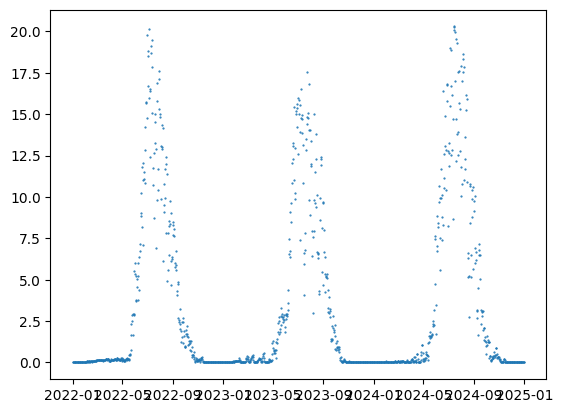

In [8]:
plt.scatter(data["se_sto"].flux.index, data["se_sto"].flux["gpp"], s = 0.3)

### Satellite

**Indices**

In [9]:
def calculate_indices(df):
    
    # Get bands
    blue = df["blue"]
    green = df["green"]
    red = df["red"]
    nir = df["nir"]
    swir_1 = df["swir_1"]
    swir_2 = df["swir_2"]
    
    # Vegetation Chlorophyll Indices
    df["ndvi"] = (nir - red) / (nir + red) # Normalised difference vegetation index
    df["msavi"] = (2 * nir + 1 - np.sqrt((2 * nir + 1) ** 2 - 8 * (nir - red))) / 2 # Modified soil adjusted index 2: Qi, J., A. Chehbouni, A. Huete, Y. Kerr, and S. Sorooshian. "A Modified Soil Adjusted Vegetation Index." Remote Sensing of Environment 48 (1994): 119-126.
    df["nirv"] = ((nir - red) / (nir + red) - 0.08) * nir # Near Infra-red index (for vegetation that deals with soil and is a proxy for SIF (which is a value required to calculate GPP!))
    df["evi"] = 2.5 * ( ( nir - red ) / ( nir + 6 * red - 7.5 * blue + 1 ) ) # Enhanced vegetation index: Huete, A., et al. "Overview of the Radiometric and Biophysical Performance of the MODIS Vegetation Indices." Remote Sensing of Environment 83 (2002):195–213.
    df["kndvi"] = np.tanh((nir - red) ** 2 / (2 * (0.5 * (nir + red)) ** 2)) # kNDVI. Kernel ndvi. better against noise and non-linearity. https://www.science.org/doi/10.1126/sciadv.abc7447 - a nice review of nirv and ndvi too!
    df["savi"] = ( 1.5 * ( nir - red ) ) / ( nir + red + 0.5 ) # soil adjusted vegetation index: Huete, A. "A Soil-Adjusted Vegetation Index (SAVI)." Remote Sensing of Environment 25 (1988): 295-309.
    df["tvi"] = 0.5 * ( 120 * ( nir - green ) - 200 * ( red - green ) ) # Triangular vegetation index. https://www.sciencedirect.com/science/article/pii/S0034425700001978?via%3Dihub
    df["cri2"] = ( 1 / green ) - ( 1 / red ) # Carotenoid reflectance index 2 (will produce some crazy values so clean it): https://onlinelibrary.wiley.com/doi/abs/10.1562/0031-8655%282001%290740038OPANEO2.0.CO2 
    df["mndvi"] = ( nir - red ) / ( nir + red - 2 * blue ) # Modified ndvi: https://www.sciencedirect.com/science/article/pii/S003442570200010X?via%3Dihub
    df["lai"] = 3.618 * ( 2.5 * ( ( nir - red ) / ( nir + 6 * red - 7.5 * blue + 1 ) ) ) - 0.118 # Leaf area index (apparently values should be no greater than 0.35??): Boegh, E., H. Soegaard, N. Broge, C. Hasager, N. Jensen, K. Schelde, and A. Thomsen. "Airborne Multi-spectral Data for Quantifying Leaf Area Index, Nitrogen Concentration and Photosynthetic Efficiency in Agriculture." Remote Sensing of Environment 81, no. 2-3 (2002): 179-193.
    df["fci2"] = red * nir # forest cover index 2: Becker, Sarah J., Craig S.T. Daughtry, and Andrew L. Russ. "Robust forest cover indices for multispectral images." Photogrammetric Engineering & Remote Sensing 84.8 (2018): 505-512.    VIA: https://mapir.gitbook.io/mapir-camera-control-mcc/multispectral-index-formulas
    df["gemi"] = ( ( 2 * ( nir*nir - red*red ) + 1.5 * nir + 0.5 * red ) / ( nir + red + 0.5 ) ) * ( 1 - 0.25 * ( ( 2 * ( nir*nir - red*red ) + 1.5 * nir + 0.5 * red ) / ( nir + red + 0.5 ) ) ) - ( ( red - 0.125 ) / ( 1 - red ) ) # global environmental monitoring index: Pinty, B., and M. Verstraete. GEMI: a Non-Linear Index to Monitor Global Vegetation From Satellites. Vegetation 101 (1992): 15-20.    VIA: https://mapir.gitbook.io/mapir-camera-control-mcc/multispectral-index-formulas
    df["gari"] = ( nir - green - 1.7 * ( blue - red ) ) / ( nir + green - 1.7 * ( blue - red ) ) # Green atmospherically resistant index: Gitelson, A., Y. Kaufman, and M. Merzylak. "Use of a Green Channel in Remote Sensing of Global Vegetation from EOS-MODIS." Remote Sensing of Environment 58 (1996): 289-298.
    df["gci"] = ( nir / green ) - 1 # Green chlorophyll index: Gitelson, A., Y. Gritz, and M. Merzlyak. "Relationships Between Leaf Chlorophyll Content and Spectral Reflectance and Algorithms for Non-Destructive Chlorophyll Assessment in Higher Plant Leaves." Journal of Plant Physiology 160 (2003): 271-282.
    df["gndvi"] = ( nir - green ) / ( nir + green ) # Green ndvi:Gitelson, A., and M. Merzlyak. "Remote Sensing of Chlorophyll Concentration in Higher Plant Leaves." Advances in Space Research 22 (1998): 689-692.
    df["gosavi"] = ( nir - green ) / ( nir + green + 0.16 ) # Green optimised savi (for predicting crop nitrogen requirements) Sripada, R., et al. "Determining In-Season Nitrogen Requirements for Corn Using Aerial Color-Infrared Photography." Ph.D. dissertation, North Carolina State University, 2005.
    #df["grvi"] = nir / green # Green ratio vegetation index (photosynthesis in forest canopy): Sripada, R., et al. "Aerial Color Infrared Photography for Determining Early In-season Nitrogen Requirements in Corn." Agronomy Journal 98 (2006): 968-977.
    df["grvi"] = ( green - red ) / ( green + red ) # greenpred vegetation index https://spj.science.org/doi/10.34133/2022/9764982
    df["gsavi"] = 1.5 * ( ( nir - green ) / ( nir + green + 0.5 ) ) # green savi (nitrogen requirements in corn): Sripada, R., et al. "Determining In-Season Nitrogen Requirements for Corn Using Aerial Color-Infrared Photography." Ph.D. dissertation, North Carolina State University, 2005.
    df["nli"] = ( nir*nir - red ) / ( nir*nir + red ) # Non-linear index: Goel, N., and W. Qin. "Influences of Canopy Architecture on Relationships Between Various Vegetation Indices and LAI and Fpar: A Computer Simulation." Remote Sensing Reviews 10 (1994): 309-347.
    df["osavi"] = ( nir - red ) / ( nir + red + 0.16 ) # optimised soil adjusted vegetation index: Rondeaux, G., M. Steven, and F. Baret. "Optimization of Soil-Adjusted Vegetation Indices." Remote Sensing of Environment 55 (1996): 95-107.
    df["tdvi"] = 1.5 * ( ( nir - red ) / np.sqrt( nir*nir + red + 0.5 ) ) # Transformed difference vegetation index (does not saturate like ndvi, for use in urban environs): Bannari, A., H. Asalhi, and P. Teillet. "Transformed Difference Vegetation Index (TDVI) for Vegetation Cover Mapping" In Proceedings of the Geoscience and Remote Sensing Symposium, IGARSS '02, IEEE International, Volume 5 (2002).
    df["wdrvi"] = ( 0.2 * nir - red ) / ( 0.2 * nir + red ) # wide dynamic range vegetation index (weights nir and red to reduce signal disparity and stop over-saturation): Gitelson, A. "Wide Dynamic Range Vegetation Index for Remote Quantification of Biophysical Characteristics of Vegetation." Journal of Plant Physiology 161, No. 2 (2004): 165-173. AND Henebry, G., A. Viña, and A. Gitelson. "The Wide Dynamic Range Vegetation Index and its Potential Utility for Gap Analysis." Gap Analysis Bulletin 12: 50-56.
    df["msrvi"] = ( ( nir ) / ( red - 1 ) ) / ( np.sqrt( nir / red ) + 1 ) # Modified simple ratio vegetation index: https://www.sciencedirect.com/science/article/pii/S0378112719304736?via%3Dihub
    df["mtvi"] = 1.2 * ( 1.2 * ( nir - green ) - 2.5 * ( red  - green ) ) # modified tvi: https://www.sciencedirect.com/science/article/pii/S0034425704000264?via%3Dihub
    df["npci"] = ( red - blue ) / ( red + blue ) # normalised pigment chlorophyll index: Penuelas, J., Baret, F., and Filella, I. 1995. “Semi-empirical indices to assess carotenoids/chlorophyll a ratio from leaf spectral reflectance.” Photosynthetica, Vol. 31(No. 2): pp. 221–230.
    df["psri"] = ( red - green ) / nir # plant senescence reflectance index: https://onlinelibrary.wiley.com/doi/10.1034/j.1399-3054.1999.106119.x
    df["rgvi"] = red / green # red-green vegetation index: https://www.sciencedirect.com/science/article/pii/S0034425705002865?via%3Dihub
    df["spectral_polygon"] = 0.4 * ( 3.7 * ( nir - red ) - 1.2 * ( green - red) ) # Spectral Polygon: Vincini, M., Frazzi, E., and D’Alessio, P. 2006. Angular dependence of maize and sugar beet VIs from directional CHRIS/Proba data. Proc. 4th ESA CHRIS PROBA Workshop, 19–21
    
    # Vegetation Water Content Indices
    df["msi"] = swir_1 / nir # Moisture Stress Index (vegetation water stress)
    df["gvmi"] = (nir + 0.1 - swir_1 + 0.02) / (nir + 0.1 + swir_1 + 0.02) # Global vegetation moisture index
    df["ndmi"] = ( nir - swir_1 ) / ( nir + swir_1 ) # nd mositure index: https://www.sciencedirect.com/science/article/pii/0273117782902435?via%3Dihub
    
    # Water Indices
    df["ndwi"] = (nir - swir_1) / (nir + swir_1) # Normalised difference water index
    df["mndwi"] = (green - swir_1) / (green + swir_1) # Modified normalised difference water index: https://www.tandfonline.com/doi/full/10.1080/01431160600589179
    df["wi"] = 1.7204 + 171 * green + 3 * red - 70 * nir - 45 * swir_1 - 71 * swir_2 # Water index. https://www.sciencedirect.com/science/article/pii/S0034425715302753
    df["andwi"] = ( blue + green + red - nir - swir_1 - swir_2 ) / ( blue + green + red + nir + swir_1 + swir_2 ) # Augmented Normalized Difference Water Index https://www.sciencedirect.com/science/article/pii/S1364815221000736?via%3Dihub#bib29
    df["mbwi"] = 2 * green - red - nir - swir_1 - swir_2 # Multiband water index. https://www.sciencedirect.com/science/article/pii/S0303243418300990?via%3Dihub
    df["muwir"] = -4 * ( (blue - green ) / ( blue + green ) ) + 2 * ( (green - nir ) / ( green + nir ) ) + 2 * ( (green - swir_2 ) / ( green + swir_2 ) ) - 1 * ( (green - swir_1 ) / ( green + swir_1 ) ) # Revised Multi-Spectral Water Index. https://www.mdpi.com/2072-4292/10/10/1643
    df["swm"] = ( blue + green ) / ( nir + swir_1 ) # Sentinel water mask. https://eoscience.esa.int/landtraining2017/files/posters/MILCZAREK.pdf
    df["wri"] = ( green + red ) / ( nir + swir_1 ) # Water ratio index: https://ieeexplore.ieee.org/document/5567762
    
    # Snow Indices
    df["tsi"] = (red - nir) / (red + nir) # Terrible snow index (not an actual index)
    df["ndsi"] = ( green - swir_1 ) / ( green + swir_1 ) # Normalised difference snow index
    df["swi"] = ( green * ( nir - swir_1 ) ) / ( green + nir ) * ( nir + swir_1 ) # Snow water index
    
    # Soil Indices
    df["bsi"] = ( ( swir_2 + red ) - (nir + blue)) / ( ( swir_2 + red ) + ( nir + blue ) ) # Barren soil index. https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/barren_soil/
    df["bi"] =  red + swir_1 + nir # Bareness index. https://ieeexplore.ieee.org/document/1525743
    df["dbsi"] = ( swir_1 - green ) / ( swir_1 + green ) # Dry bare soil index  https://www.mdpi.com/2073-445X/7/3/81
    df["bitm"] = np.sqrt( ( ( blue * blue ) + ( green * green ) + ( red * red ) ) / 3 ) # Brightness index. Soil reflectance magnitude. https://www.sciencedirect.com/science/article/pii/S0034425798000303?via%3Dihub
    df["nsdsi1"] = ( swir_1 - swir_2 ) / swir_1 # Normalized Shortwave-Infrared Difference Bare Soil Moisture Index. https://www.sciencedirect.com/science/article/pii/S0924271619301522?via%3Dihub
    df["nsdsi2"] = ( swir_1 - swir_2 ) / swir_2 # Normalized Shortwave-Infrared Difference Bare Soil Moisture Index. https://www.sciencedirect.com/science/article/pii/S0924271619301522?via%3Dihub
    df["nsdsi3"] = ( swir_1 - swir_2 ) / ( swir_1 + swir_2 ) # Normalized Shortwave-Infrared Difference Bare Soil Moisture Index. https://www.sciencedirect.com/science/article/pii/S0924271619301522?via%3Dihub
    df["bsmi"] = ( swir_1 - red ) / ( swir_1 + red ) # Bare soil moisture index
    
    # Other
    df["ndpi"] = ( swir_1 - green ) / ( swir_1 + green ) # Normalised difference pond index (maybe useful for bog?). https://www.sciencedirect.com/science/article/pii/S0034425706002811?via%3Dihub
    df["nbr2"] = (swir_1 - swir_2) / (swir_1 + swir_2) # Normalised burn ratio 2. For burn but useful for water
    
    # Clean Invalid Values
    # Some indices will give out of bounds values. Out of bounds for the index (e.g. above 1) or Nan or Inf.
    # Lots of our indices must be within -1 and 1, otherwise the values are invalid.
    indices = [
        "ndvi", "evi", "savi", "mndvi", "gemi", "gari", "gndvi", "gosavi", "grvi", "gsavi", "nli", "osavi", "tdvi", "wdrvi", "npci", 
        "gvmi", "ndmi",
        "ndwi", "mndwi", "andwi",
        "tsi", "ndsi", "swi",
        "bsi", "dbsi", "nsdsi3", "bsmi",
        "ndpi", "nbr2"
        ]
    for col_name in indices:
        df = df[df[col_name].between(-1, 1)]
    
    # Some must be within 0 and 1
    indices = ["kndvi"]
    for col_name in indices:
        df = df[df[col_name].between(-1, 1)]
    
    # cri2 can sometimes give some wild values, let's keep them between a decent range...
    indices = ["cri2"]
    for col_name in indices:
        df = df[df[col_name].between(-20, 20)]
        
    # Replace inf/-inf with NaN, then drop
    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    df.dropna(inplace = True)  # or X.fillna(X.mean(), inplace = True)
    
    return df

**Lagging**

In [10]:
def add_lagged_features(df, lags, interpolate_method='linear', interpolate_order=2):
    """
    Create lagged features for numeric columns in a DataFrame indexed by datetime.
    
    # e.g. df_with_lags = add_lagged_features(df, lags=[1, 3, 7])
    
    Parameters:
    - df: pd.DataFrame with a datetime index
    - lags: list of integers representing lag days (e.g., [1, 3, 7])
    - interpolate_method: method to fill missing values after shifting (default 'linear')
    - interpolate_order: spline order if using spline interpolation (default 2)
    
    Returns:
    - pd.DataFrame with original columns plus lagged columns suffixed by '_lag_<lag>'
    """
    df_new = df.copy()
    
    # Select numeric columns only
    df_num = df_new.select_dtypes(include=np.number)
    
    # Group by date and aggregate by mean to remove duplicates per day
    num_cols = df_num.columns.tolist()
    agg_dict = {col: 'mean' for col in num_cols}
    df_num = df_num.groupby(df_num.index.date).agg(agg_dict)
    
    # Reindex to full daily range to fill in missing dates
    df_num.index = pd.to_datetime(df_num.index)
    full_idx = pd.date_range(start=df_num.index.min(), end=df_num.index.max(), freq='D')
    df_num = df_num.reindex(full_idx)
    
    lag_list = []
    
    for lag in lags:
        # Shift by lag days
        df_lagged = df_num.shift(lag)
        
        # Interpolate missing values after shifting
        if interpolate_method == 'spline':
            df_interpolated = df_lagged.interpolate(method='spline', order=interpolate_order,
                                                   limit_direction='both', limit=lag)
        else:
            df_interpolated = df_lagged.interpolate(method=interpolate_method,
                                                    limit_direction='both', limit=lag)
        
        # Rename columns to indicate lag
        df_interpolated = df_interpolated.add_suffix(f'_lag_{lag}')
        
        # Align lagged dataframe with original dataframe dates (normalize to date only)
        df_new_dates = df_new.index.normalize()
        df_interpolated.index = df_interpolated.index.normalize()
        
        lagged_aligned = df_interpolated.reindex(df_new_dates.values)
        lagged_aligned.index = df_new.index  # keep original timestamp index
        
        lag_list.append(lagged_aligned)
    
    # Concatenate all lagged features and join to original dataframe
    lag_df = pd.concat(lag_list, axis=1)
    df_new = pd.concat([df_new, lag_df], axis=1)
    
    # Drop initial rows with NaNs due to max lag shift
    max_lag = max(lags)
    df_new = df_new.iloc[max_lag:]
    
    return df_new

def add_lagged_direction_features(df, lags, tolerance=1e-8, interpolate_method='linear', interpolate_order=2):
    """
    Create lagged directional features for numeric columns in a DataFrame indexed by datetime.
    Each lagged feature indicates if current value is higher (1), lower (-1), or similar (0)
    compared to the lagged value.
    
    e.g. df_with_direction_lags = add_lagged_direction_features(df, lags=[1, 3, 7])
    
    Parameters:
    - df: pd.DataFrame with datetime index
    - lags: list of integers for lag days (e.g., [1, 3, 7])
    - tolerance: float, values within this difference are considered 'similar' (default 1e-8)
    - interpolate_method: method to interpolate missing lagged values (default 'linear')
    - interpolate_order: order for spline interpolation (default 2)
    
    Returns:
    - pd.DataFrame with original columns plus lagged directional columns suffixed by '_lag_dir_<lag>'
    """
    df_new = df.copy()
    
    # Select numeric columns only
    df_num = df_new.select_dtypes(include=np.number)
    
    # Aggregate duplicates by mean for each date
    agg_dict = {col: 'mean' for col in df_num.columns}
    df_num = df_num.groupby(df_num.index.date).agg(agg_dict)
    
    # Convert index to datetime and reindex to full daily range
    df_num.index = pd.to_datetime(df_num.index)
    full_idx = pd.date_range(start=df_num.index.min(), end=df_num.index.max(), freq='D')
    df_num = df_num.reindex(full_idx)
    
    direction_lag_list = []
    
    for lag in lags:
        # Shift lagged values
        df_lagged = df_num.shift(lag)
        
        # Interpolate missing lagged values
        if interpolate_method == 'spline':
            df_interpolated = df_lagged.interpolate(method='spline', order=interpolate_order,
                                                   limit_direction='both', limit=lag)
        else:
            df_interpolated = df_lagged.interpolate(method=interpolate_method,
                                                    limit_direction='both', limit=lag)
        
        # Align lagged dataframe with original dataframe dates (normalize index)
        df_new_dates = df_new.index.normalize()
        df_interpolated.index = df_interpolated.index.normalize()
        lagged_aligned = df_interpolated.reindex(df_new_dates.values)
        lagged_aligned.index = df_new.index  # restore original index with time
        
        # Compare current values with lagged values
        df_current = df_new[df_num.columns]  # original numeric columns aligned with df_new
        
        # Ensure columns align for comparison
        df_current = df_current.loc[lagged_aligned.index, df_num.columns]
        
        # Compute difference and apply tolerance for "similar"
        diff = df_current - lagged_aligned
        
        direction = pd.DataFrame(0, index=df_current.index, columns=[f"{col}_lag_dir_{lag}" for col in df_current.columns])
        
        # Set 1 where current > lagged + tolerance
        direction[diff > tolerance] = 1
        # Set -1 where current < lagged - tolerance
        direction[diff < -tolerance] = -1
        # 0 otherwise (including NaNs)
        
        direction_lag_list.append(direction)
    
    # Concatenate all direction lagged features and join to original df
    direction_lag_df = pd.concat(direction_lag_list, axis=1)
    df_new = pd.concat([df_new, direction_lag_df], axis=1)
    
    # Drop rows at the start that have incomplete lag data due to shift
    max_lag = max(lags)
    df_new = df_new.iloc[max_lag:]
    
    return df_new

def add_lagged_direction_features_var_tolerance_v2(df, lags, tolerance_proportion=0.01, 
                                                   interpolate_method='linear', interpolate_order=2):
    import numpy as np
    import pandas as pd

    df_new = df.copy()
    
    # Select numeric columns only
    df_num = df_new.select_dtypes(include=np.number)
    df_num = df_num.loc[:, ~df_num.columns.str.contains('lag')] # in case we've run the other lag function before this one.
    
    # Calculate variance per column on original data (dropna)
    variance = df_num.var()
    
    # Aggregate duplicates by mean for each date
    agg_dict = {col: 'mean' for col in df_num.columns}
    df_num_agg = df_num.groupby(df_num.index.date).agg(agg_dict)
    
    # Convert index to datetime and reindex to full daily range
    df_num_agg.index = pd.to_datetime(df_num_agg.index)
    full_idx = pd.date_range(start=df_num_agg.index.min(), end=df_num_agg.index.max(), freq='D')
    df_num_agg = df_num_agg.reindex(full_idx)
    
    direction_lag_list = []
    
    for lag in lags:
        df_lagged = df_num_agg.shift(lag)
        
        if interpolate_method == 'spline':
            df_interpolated = df_lagged.interpolate(method='spline', order=interpolate_order,
                                                    limit_direction='both', limit=lag)
        else:
            df_interpolated = df_lagged.interpolate(method=interpolate_method,
                                                    limit_direction='both', limit=lag)
        
        # Create a DataFrame to merge with original data
        lagged_df = df_interpolated.copy()
        lagged_df.index.name = 'date'
        lagged_df.reset_index(inplace=True)
        
        # Prepare original df with a date column to merge on
        df_merge = df_new.copy()
        #df_merge['date'] = df_merge.index.date
        df_merge['date'] = pd.to_datetime(df_merge.index.date)
        
        # Merge lagged with original on 'date'
        merged = pd.merge(df_merge, lagged_df, how='left', on='date', suffixes=('', f'_abslag_{lag}'))
        
        # Compute direction per column
        direction = pd.DataFrame(0, index=merged.index, columns=[f"{col}_lag_dir_{lag}" for col in df_num.columns])
        
        for col in df_num.columns:
            tol = variance[col] * tolerance_proportion
            
            current_vals = merged[col]
            lagged_vals = merged[f"{col}_abslag_{lag}"]
            
            diff = current_vals - lagged_vals
            
            direction.loc[diff > tol, f"{col}_lag_dir_{lag}"] = 1
            direction.loc[diff < -tol, f"{col}_lag_dir_{lag}"] = -1
        
        direction_lag_list.append(direction)
    
    direction_lag_df = pd.concat(direction_lag_list, axis=1)
    
    # Join the direction lag columns back to original df_new
    df_new = pd.concat([df_new.reset_index(drop=True), direction_lag_df.reset_index(drop=True)], axis=1)
    
    # Drop initial rows where lag features would be incomplete
    max_lag = max(lags)
    df_new = df_new.iloc[max_lag:]
    
    # Restore original index (if needed)
    df_new.index = df.index[max_lag:]
    
    return df_new

In [11]:
for key, item in data.items():
    item.satellite = calculate_indices(item.satellite)
    #item.satellite = add_lagged_features(item.satellite, lags=[1, 3, 7])
    #item.satellite = add_lagged_direction_features(item.satellite, lags=[1, 3, 7])
    #item.satellite = add_lagged_direction_features_var_tolerance_v2(item.satellite, lags=[1,3,7], tolerance_proportion=0.02)

c:\Users\Laurie\Desktop\arctic-ecosystems\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Laurie\Desktop\arctic-ecosystems\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Laurie\Desktop\arctic-ecosystems\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Laurie\Desktop\arctic-ecosystems\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Laurie\Desktop\arctic-ecosystems\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Us

# IN PROGESS - Platform Harmonization Check

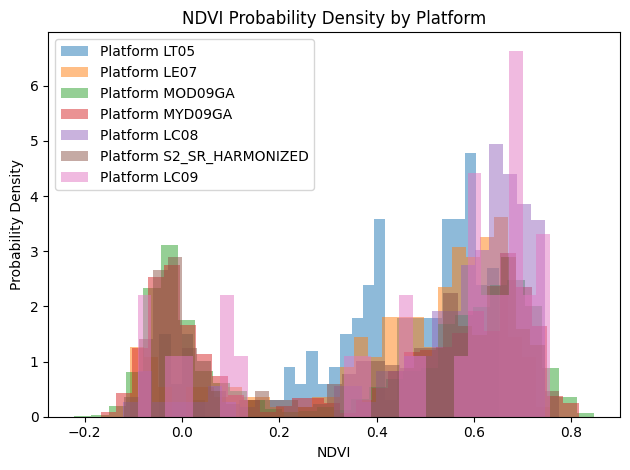

In [9]:
# Extract the satellite DataFrame
satellite_data = data["se_st1"].satellite

# Get unique platform IDs
platform_ids = satellite_data["platform_id"].unique()

# Create PDF histogram for each platform
for pid in platform_ids:
    ndvi_vals = satellite_data[satellite_data["platform_id"] == pid]["ndvi"]
    plt.hist(ndvi_vals, bins=30, alpha=0.5, density=True, label=f'Platform {pid}')

# Plot formatting
plt.xlabel("NDVI")
plt.ylabel("Probability Density")
plt.title("NDVI Probability Density by Platform")
plt.legend()
plt.tight_layout()
plt.show()

Number of common dates: 66
ANOVA results: F = 1.019, p = 0.3621


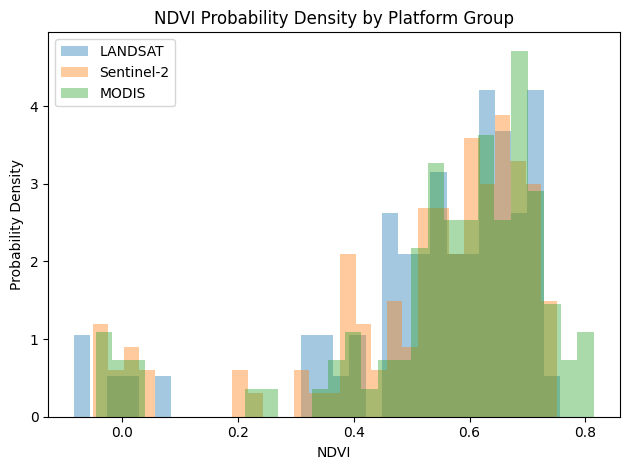

In [10]:
from scipy.stats import f_oneway

# Extract the satellite DataFrame
satellite_data = data["se_st1"].satellite

# Define a function to group platform IDs
def group_platform(pid):
    pid_upper = pid.upper()
    if "L" in pid_upper:
        return "LANDSAT"
    elif "SR" in pid_upper:
        return "Sentinel-2"
    elif "M" in pid_upper:
        return "MODIS"
    else:
        return pid

# Add a new column for grouped platform IDs
satellite_data["platform_group"] = satellite_data["platform_id"].apply(group_platform)

# Filter to include only the desired groups
groups_of_interest = ["LANDSAT", "Sentinel-2", "MODIS"]
grouped_data = satellite_data[satellite_data["platform_group"].isin(groups_of_interest)]

# Get unique dates per platform group
grouped_data["date"] = grouped_data.index.date
dates_landsat = set(grouped_data[grouped_data["platform_group"] == "LANDSAT"]["date"].unique())
dates_sentinel = set(grouped_data[grouped_data["platform_group"] == "Sentinel-2"]["date"].unique())
dates_modis = set(grouped_data[grouped_data["platform_group"] == "MODIS"]["date"].unique())

common_dates = dates_landsat & dates_sentinel & dates_modis
print(f"Number of common dates: {len(common_dates)}")

grouped_data = grouped_data[grouped_data["date"].isin(common_dates)].copy()

# Extract NDVI values for each group
landsat_vals = grouped_data[grouped_data["platform_group"] == "LANDSAT"]["ndvi"].dropna()
sentinel_vals = grouped_data[grouped_data["platform_group"] == "Sentinel-2"]["ndvi"].dropna()
modis_vals = grouped_data[grouped_data["platform_group"] == "MODIS"]["ndvi"].dropna()

# Perform ANOVA test
f_stat, p_value = f_oneway(landsat_vals, sentinel_vals, modis_vals)
print(f"ANOVA results: F = {f_stat:.3f}, p = {p_value:.4f}")

# Plot histograms
for group, values in zip(["LANDSAT", "Sentinel-2", "MODIS"], [landsat_vals, sentinel_vals, modis_vals]):
    plt.hist(values, bins=30, alpha=0.4, density=True, label=group)

# Plot formatting
plt.xlabel("NDVI")
plt.ylabel("Probability Density")
plt.title("NDVI Probability Density by Platform Group")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Prepare the data: keep only relevant rows and columns
tukey_data = grouped_data[["ndvi", "platform_group"]].dropna()

# Run Tukey's HSD test
tukey_result = pairwise_tukeyhsd(
    endog=tukey_data["ndvi"],         # Dependent variable
    groups=tukey_data["platform_group"],  # Grouping variable
    alpha=0.05                        # Significance level
)

# Print summary
print(tukey_result.summary())

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
LANDSAT      MODIS   0.0239 0.7299 -0.0505 0.0982  False
LANDSAT Sentinel-2  -0.0147 0.8768 -0.0853  0.056  False
  MODIS Sentinel-2  -0.0385 0.3289 -0.1022 0.0251  False
--------------------------------------------------------


C:\Users\Laurie\AppData\Local\Temp\ipykernel_20140\1065483654.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="platform_group", y="ndvi", data=grouped_data, palette="Set2")


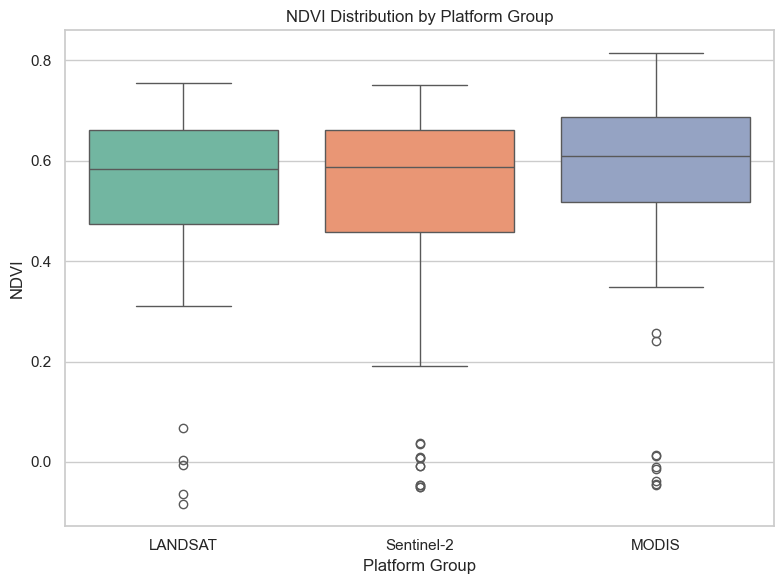

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="platform_group", y="ndvi", data=grouped_data, palette="Set2")

# Format plot
plt.title("NDVI Distribution by Platform Group")
plt.xlabel("Platform Group")
plt.ylabel("NDVI")
plt.tight_layout()
plt.show()

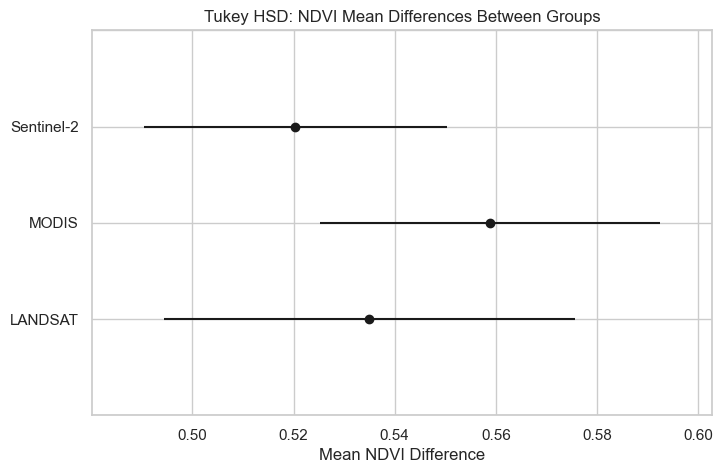

In [13]:
tukey_result.plot_simultaneous(figsize=(8, 5))
plt.title("Tukey HSD: NDVI Mean Differences Between Groups")
plt.xlabel("Mean NDVI Difference")
plt.grid(True)
plt.show()

ANOVA on standardized NDVI: F = 0.000, p = 1.0000


C:\Users\Laurie\AppData\Local\Temp\ipykernel_20140\1186438876.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="platform_group", y="ndvi_std", data=df, palette="Set2")


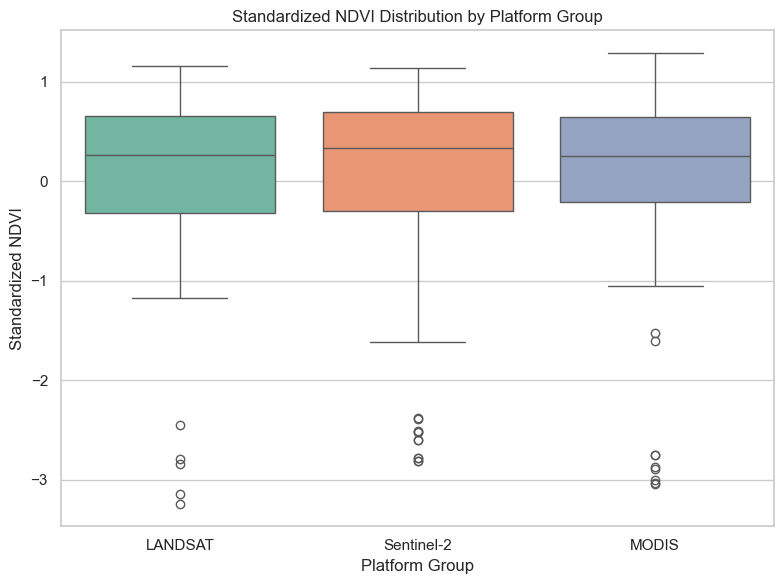

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2   meandiff p-adj  lower  upper  reject
-------------------------------------------------------
LANDSAT      MODIS      0.0   1.0 -0.3734 0.3734  False
LANDSAT Sentinel-2      0.0   1.0  -0.355  0.355  False
  MODIS Sentinel-2     -0.0   1.0 -0.3197 0.3197  False
-------------------------------------------------------


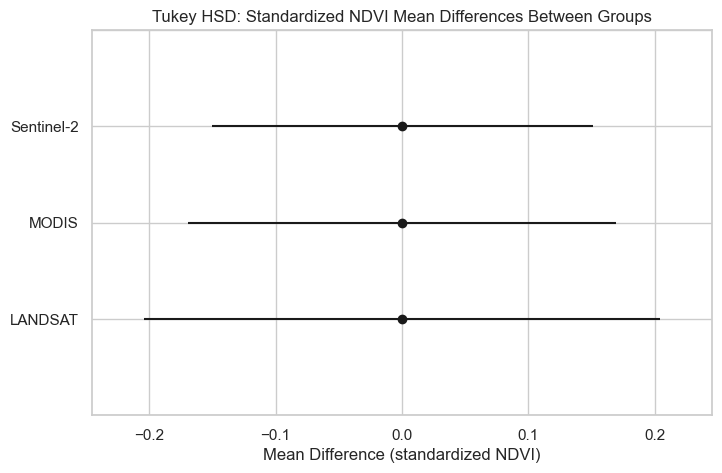

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

# Copy data to avoid modifying original
df = grouped_data.copy()

# Standardize NDVI within each platform group
df["ndvi_std"] = df.groupby("platform_group")["ndvi"].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Extract standardized NDVI values for each group
landsat_std = df[df["platform_group"] == "LANDSAT"]["ndvi_std"].dropna()
sentinel_std = df[df["platform_group"] == "Sentinel-2"]["ndvi_std"].dropna()
modis_std = df[df["platform_group"] == "MODIS"]["ndvi_std"].dropna()

# Perform ANOVA on standardized values
f_stat_std, p_value_std = f_oneway(landsat_std, sentinel_std, modis_std)
print(f"ANOVA on standardized NDVI: F = {f_stat_std:.3f}, p = {p_value_std:.4f}")

# Plot boxplot of standardized NDVI by platform group
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.boxplot(x="platform_group", y="ndvi_std", data=df, palette="Set2")
plt.title("Standardized NDVI Distribution by Platform Group")
plt.xlabel("Platform Group")
plt.ylabel("Standardized NDVI")
plt.tight_layout()
plt.show()

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Prepare data for Tukey's HSD
tukey_data_std = df[["ndvi_std", "platform_group"]].dropna()

# Run Tukey's HSD test on standardized NDVI
tukey_result_std = pairwise_tukeyhsd(
    endog=tukey_data_std["ndvi_std"],      # Dependent variable (standardized NDVI)
    groups=tukey_data_std["platform_group"],  # Grouping variable
    alpha=0.05
)

# Print the summary of Tukey's HSD results
print(tukey_result_std.summary())

# Optional: plot confidence intervals for group differences
tukey_result_std.plot_simultaneous(figsize=(8, 5))
plt.title("Tukey HSD: Standardized NDVI Mean Differences Between Groups")
plt.xlabel("Mean Difference (standardized NDVI)")
plt.grid(True)
plt.show()

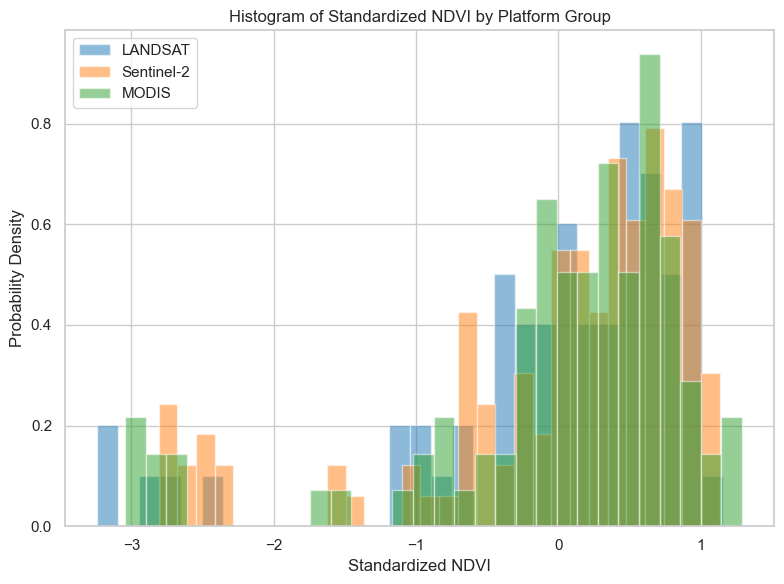

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

groups = ["LANDSAT", "Sentinel-2", "MODIS"]
colors = ["tab:blue", "tab:orange", "tab:green"]

for group, color in zip(groups, colors):
    values = df[df["platform_group"] == group]["ndvi_std"].dropna()
    plt.hist(values, bins=30, alpha=0.5, density=True, label=group, color=color)

plt.xlabel("Standardized NDVI")
plt.ylabel("Probability Density")
plt.title("Histogram of Standardized NDVI by Platform Group")
plt.legend()
plt.tight_layout()
plt.show()

#### Lin regress harmonization

In [16]:
#import statsmodels.api as sm
#import numpy as np
#
## Prepare combined reference NDVI as the mean of MODIS and Sentinel-2
#grouped_data["ndvi_ref"] = grouped_data.apply(
#    lambda row: np.nan, axis=1
#)
## Assign reference NDVI as mean of MODIS and Sentinel-2 on the same date & location
## Simplified here as the average of means on that date — adjust if you have pixel-level matching
#
## Aggregate mean NDVI of MODIS and Sentinel-2 per date (or better, per location + date if available)
#ref_means = grouped_data[grouped_data["platform_group"].isin(["MODIS", "Sentinel-2"])] \
#    .groupby("date")["ndvi"].mean()
#
## Map reference means to Landsat rows by date
#grouped_data.loc[grouped_data["platform_group"] == "LANDSAT", "ndvi_ref"] = \
#    grouped_data.loc[grouped_data["platform_group"] == "LANDSAT", "date"].map(ref_means)
#
## Filter Landsat rows with both NDVI and reference NDVI available
#landsat_data = grouped_data[(grouped_data["platform_group"] == "LANDSAT") & 
#                            (~grouped_data["ndvi"].isna()) & 
#                            (~grouped_data["ndvi_ref"].isna())]
#
## Linear regression: ndvi_ref = a + b * ndvi_landsat
#X = landsat_data["ndvi"]
#y = landsat_data["ndvi_ref"]
#X = sm.add_constant(X)  # Adds intercept term
#
#model = sm.OLS(y, X).fit()
#print(model.summary())
#
## Apply correction: ndvi_corrected = (ndvi - intercept) / slope
#intercept, slope = model.params
#
#grouped_data["ndvi_corrected"] = grouped_data.apply(
#    lambda row: (row["ndvi"] - intercept) / slope if row["platform_group"] == "LANDSAT" else row["ndvi"],
#    axis=1
#)
#

# Prepare Training Data

**Pair the Flux Tower and Satellite Data by Datetime**

In [12]:
for key, item in data.items():
    
    df_flux = item.flux.copy()
    df_satellite = item.satellite.copy()
    
    # Clip satellite to flux tower min and max times
    df_flux["datetime"] = df_flux.index
    df_satellite["datetime"] = df_satellite.index
    datetime_start = df_flux["datetime"].min()
    datetime_end = df_flux["datetime"].max()
    df_satellite = df_satellite.dropna(subset = ["datetime"])
    df_satellite_subset = df_satellite[(df_satellite["datetime"] >= datetime_start) & (df_satellite["datetime"] <= datetime_end)]
    
    # Merge Satellite and Flux data by nearest datetime column values
    df_paired = pd.merge_asof(
        df_satellite_subset.sort_index(), df_flux.sort_index(), # should be sorted already, but why take the chance!
        left_on = "datetime", right_on = "datetime",
        direction = "nearest",
        suffixes = ("", "_flux") # keep satellite cols without suffix so that when we apply the random forest model we dont have to change col names. Append _flux to duplicate flux cols
    )
    
    # Set index on new paired dataframe
    df_paired = df_paired.set_index("datetime")
    df_paired.rename_axis(None, inplace = True) # Remove the index column header (otherwise using .merge won"t work when creating the paired dataset). This was done during cleaning for flux data
    
    data[key].paired = df_paired

### Stuff that should eventually be put into the sklearn pipeline

**Detrend?? non-stationarity etc.**

**Z-Score Outlier Removal??**

from scipy.stats import zscore
df = df[(np.abs(zscore(df.select_dtypes(include=[np.number]))) < 3).all(axis=1)]

**Gap-filling?**

**Feature Engineering**

Potential Feature Engineering:

- Cyclical time stuff = DONE
- Lagged features (1 day, 3 days, 1 week, 1 month. Rolling mean features) = DONE
- Get more features (scene cloudiness, contrast, texture, etc.) = DONE
- Interaction features (use friedmans H stat (sklearn gbmi)). See: https://towardsdatascience.com/feature-interactions-524815abec81/
    Also use: from sklearn.preprocessing import PolynomialFeatures
            poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
            See: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
- PCA feature reduction (incase of correlated features e.g. bands):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=5)
    pca_features = pca.fit_transform(df[cols])


Maybe use: https://docs.featuretools.com/en/stable/ for automated feature engineering?

In [13]:
# A fourier version?
#def add_fourier_terms(df, time_col, period, order):
#    t = pd.to_datetime(df[time_col]).astype(int) / 1e9  # convert to seconds
#    for i in range(1, order + 1):
#        df[f'sin_{period}_{i}'] = np.sin(2 * np.pi * i * t / period)
#        df[f'cos_{period}_{i}'] = np.cos(2 * np.pi * i * t / period)
#    return df


# Day of year, week of year, month of year
def gen_time_features(df):
    df["datetime"] = df.index
    
    # Make time of day cyclical feature
    df["time_of_day"] = [datetime.combine(date(2025, 5, 24), t) for t in df["datetime"].dt.time] # Add Time of Day with arbitrary date. https://stackoverflow.com/questions/32832431/how-to-use-datetime-time-to-plot
    df['time_of_day_frac'] = ( # Convert "time_of_day" from datetime object into milliseconds
        df['time_of_day'].dt.hour * 3600000 +
        df['time_of_day'].dt.minute * 60000 +
        df['time_of_day'].dt.second * 1000 +
        df['time_of_day'].dt.microsecond // 1000
    )  / 86400000.0 # convert to fraction of day 0 - 0.999...
    df['time_of_day_sin'] = np.sin(2 * np.pi * df['time_of_day_frac'])
    df['time_of_day_cos'] = np.cos(2 * np.pi * df['time_of_day_frac'])
    
    # Make day of year cyclical feature
    days_in_year = df["datetime"].dt.is_leap_year.replace({True: 366, False: 365}) # deal with leap years
    df["day_of_year"] = df["datetime"].dt.dayofyear # Add Day of Year. Returns 1 for January 1st
    df['day_of_year_sin'] = np.sin(2 * np.pi * df["day_of_year"] / days_in_year) # convert into a cyclical features (https://harrisonpim.com/blog/the-best-way-to-encode-dates-times-and-other-cyclical-features)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df["day_of_year"] / days_in_year)
    
    # Make week of year cyclical feature
    df["week_of_year"] = df["datetime"].dt.isocalendar().week
    df['week_of_year_sin'] = np.sin(2 * np.pi * df["week_of_year"] / 52)
    df['week_of_year_cos'] = np.cos(2 * np.pi * df["week_of_year"] / 52)
    
    # Make month of year cyclical feature
    df["month_of_year"] = df["datetime"].dt.month
    df['month_of_year_sin'] = np.sin(2 * np.pi * df["month_of_year"] / 12)
    df['month_of_year_cos'] = np.cos(2 * np.pi * df["month_of_year"] / 12)
    
    # Clean up
    df.drop(["datetime", "time_of_day", "time_of_day_frac", "day_of_year", "week_of_year", "month_of_year"], axis = 1, inplace = True)

for key, item in data.items():
    
    gen_time_features(item.paired)
    gen_time_features(item.satellite)


C:\Users\Laurie\AppData\Local\Temp\ipykernel_17704\1971587160.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  days_in_year = df["datetime"].dt.is_leap_year.replace({True: 366, False: 365}) # deal with leap years
C:\Users\Laurie\AppData\Local\Temp\ipykernel_17704\1971587160.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  days_in_year = df["datetime"].dt.is_leap_year.replace({True: 366, False: 365}) # deal with leap years
C:\Users\Laurie\AppData\Local\Temp\ipykernel_17704\1971587160.py:26: FutureWarning: Downcasting behavi

**Preview**

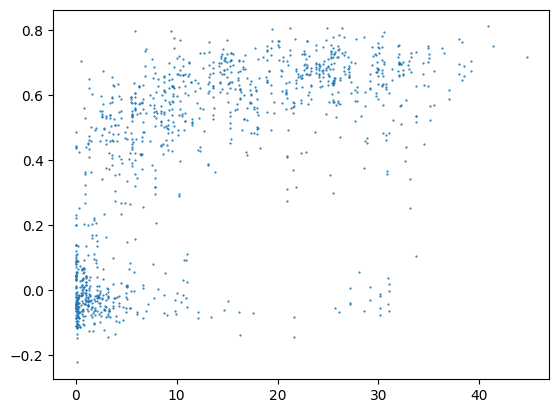

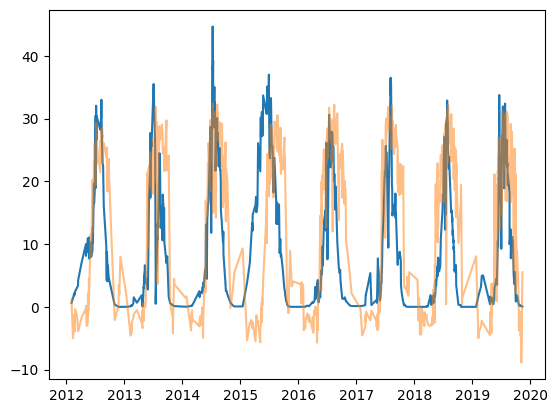

In [14]:
plt.scatter(data["se_st1"].paired["gpp"], data["se_st1"].paired["ndvi"], s = 0.3)
plt.show()
plt.plot(data["se_st1"].paired["gpp"])
plt.plot(data["se_st1"].paired["ndvi"] * 40, alpha = 0.5)
plt.show()

**Drop Unwanted Columns**

In [15]:
drop_cols = [
    #"time_of_day_sin", "time_of_day_cos",
    "day_of_year_sin", "day_of_year_cos",
    #"week_of_year_sin", "week_of_year_cos",
    #"month_of_year_sin", "month_of_year_cos",
    "platform_id", # doesn't make any difference so get rid of it to simplify training.
    #"solar_elevation",
    #"blue", "green", "red", "nir", "swir_1", "swir_2",
    #no longer needed#"unixtime", "datetime", "time_of_day", "day_of_year", "unixtime_flux", "swc_1", "swc_2", "time_of_day_flux", "day_of_year_flux", "day_of_year_cos_flux", "day_of_year_sin_flux", "time_of_day_cos_flux", "time_of_day_frac_flux", "time_of_day_sin_flux", "unixtime_flux", "time_of_day_frac"
    ]

for key, item in data.items():
    df_undropped = item.paired.copy()
    data[key].training = df_undropped.drop(columns = drop_cols, errors = "ignore")

# Random Forest Regressor Modules
Using our paired dataset we can now use a random forest decision tree to train a regressor model to quantify the relationship between our satellite data and flux tower gross primary production.

## Pipeline Subfunctions

In [16]:
class HighCorrelationFilter(BaseEstimator, SelectorMixin):
    def __init__(self, threshold = 0.9):
        self.threshold = threshold
        self.to_drop_ = []
        self.support_mask_ = None

    def fit(self, X, y=None):
        # Convert to DataFrame if needed
        X_df = pd.DataFrame(X)

        # Compute correlation matrix
        corr_matrix = X_df.corr().abs()
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        # Find features to drop
        self.to_drop_ = [col for col in upper_triangle.columns if any(upper_triangle[col] > self.threshold)]

        # Create support mask
        self.support_mask_ = np.array([col not in self.to_drop_ for col in X_df.columns])

        return self

    def _get_support_mask(self):
        if self.support_mask_ is None:
            raise ValueError("fit must be called before get_support()")
        return self.support_mask_

    def transform(self, X):
        # Apply support mask
        X_df = pd.DataFrame(X)
        return X_df.loc[:, self._get_support_mask()]

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return None
        mask = self._get_support_mask()
        return np.array(input_features)[mask]

class rfecv_feature_filter(BaseEstimator, SelectorMixin):
    def __init__(self, no_kfolds=3, seed=2):
        self.no_kfolds = no_kfolds
        self.seed = seed
        self.support_mask_ = None
        self.selector_ = None

    def fit(self, X, y):
        
        # Ensure X is a DataFrame for column alignment
        X_df = pd.DataFrame(X)
        
        # Use RandomForestRegressor as the base estimator
        estimator = RandomForestRegressor(random_state=self.seed)

        # Cross-validation strategy
        #cv = KFold(n_splits=self.no_kfolds, shuffle=False, random_state=self.seed) # NEVER SHUFFLE A TIMESERIES
        cv = TimeSeriesSplit(n_splits = self.no_kfolds) # Makes sure test data is after train data in each kfold.
        
        scorer = make_scorer(mean_squared_error, greater_is_better=False)
        
        # Run RFECV
        self.selector_ = RFECV(estimator, step=1, cv=cv, scoring=scorer)
        self.selector_.fit(X_df, y)

        # Store the mask
        self.support_mask_ = self.selector_.support_

        return self

    def transform(self, X):
        X_df = pd.DataFrame(X)
        return X_df.loc[:, self._get_support_mask()]

    def _get_support_mask(self):
        if self.support_mask_ is None:
            raise ValueError("fit must be called before get_support()")
        return self.support_mask_

    def get_support(self):
        return self._get_support_mask()

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return None
        mask = self._get_support_mask()
        return np.array(input_features)[mask]

class TreeBasedFeatureSelector(BaseEstimator, SelectorMixin):
    def __init__(self, threshold="mean", seed=2):
        self.threshold = threshold
        self.seed = seed
        self.support_mask_ = None
        self.selector_ = None
        self.feature_importances_ = None

    def fit(self, X, y):
        # Ensure input is DataFrame for feature name handling
        X_df = pd.DataFrame(X)

        # Fit Random Forest
        rf = RandomForestRegressor(n_estimators=300, random_state=self.seed)
        rf.fit(X_df, y)
        self.feature_importances_ = pd.Series(rf.feature_importances_, index=X_df.columns)

        # SelectFromModel based on importance
        self.selector_ = SelectFromModel(rf, threshold=self.threshold)
        self.selector_.fit(X_df, y)

        # Store mask
        self.support_mask_ = self.selector_.get_support()

        selected_columns = X_df.columns[self.support_mask_]
        selected_importances = self.feature_importances_[self.support_mask_]

        return self

    def transform(self, X):
        X_df = pd.DataFrame(X)
        return X_df.loc[:, self.get_support_mask()]

    def get_support_mask(self):
        if self.support_mask_ is None:
            raise ValueError("fit must be called before get_support()")
        return self.support_mask_

    def get_support(self):
        return self.get_support_mask()

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return None
        mask = self.get_support_mask()
        return np.array(input_features)[mask]

    # Implement the required _get_support_mask method from SelectorMixin
    def _get_support_mask(self):
        if self.support_mask_ is None:
            raise ValueError("fit must be called before _get_support_mask()")
        return self.support_mask_

class RollingMeanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window=5, min_periods=1):
        """
        Parameters:
        - window: int, size of the moving window (causal, looks at current and previous values)
        - min_periods: int, minimum observations required in window to compute mean
        """
        self.window = window
        self.min_periods = min_periods

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X.copy()
        rolled = X_df.rolling(window=self.window, min_periods=self.min_periods, center=False).mean()

        if hasattr(X, "columns") and hasattr(X, "index"):
            rolled.columns = X.columns
            rolled.index = X.index

        return rolled.values if not isinstance(X, pd.DataFrame) else rolled

    def set_output(self, transform=None):
        return self

class WhittakerSmoother(BaseEstimator, TransformerMixin):
    def __init__(self, lam=1e4, diff_order=1):
        self.lam = lam
        self.diff_order = diff_order

    def fit(self, X, y=None):
        return self  # no fitting necessary

    def transform(self, X):
        # Ensure DataFrame or convert to 2D NumPy array
        if isinstance(X, pd.DataFrame):
            return X.apply(lambda col: whittaker_smooth(col.values, lam=self.lam, diff_order=self.diff_order), axis=0)
        elif isinstance(X, np.ndarray):
            if X.ndim == 1:
                return whittaker_smooth(X, lam=self.lam, diff_order=self.diff_order)
            elif X.ndim == 2:
                return np.apply_along_axis(
                    lambda col: whittaker_smooth(col, lam=self.lam, diff_order=self.diff_order),
                    axis=0, arr=X
                )
            else:
                raise ValueError("Input array must be 1D or 2D.")
        else:
            raise TypeError("Input must be a pandas DataFrame or a NumPy array.")

class KalmanSmootherTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, process_var=1e-5, measurement_var=1e-1):
        self.process_var = process_var
        self.measurement_var = measurement_var

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        import pandas as pd

        X_np = np.asarray(X)
        n_samples, n_features = X_np.shape
        smoothed = np.zeros_like(X_np)

        for feature_idx in range(n_features):
            smoothed[:, feature_idx] = self._kalman_smooth(X_np[:, feature_idx])

        if hasattr(X, "columns") and hasattr(X, "index"):
            return pd.DataFrame(smoothed, columns=X.columns, index=X.index)
        else:
            return smoothed

    def _kalman_smooth(self, data):
        n = len(data)

        kf = KalmanFilter(dim_x=1, dim_z=1)
        # State transition matrix
        kf.F = np.array([[1]])
        # Measurement function
        kf.H = np.array([[1]])
        # Covariance matrix for process noise
        kf.Q = np.array([[self.process_var]])
        # Covariance matrix for measurement noise
        kf.R = np.array([[self.measurement_var]])
        # Initial state
        kf.x = np.array([[data[0]]])
        # Initial covariance
        kf.P = np.eye(1)

        filtered = np.zeros(n)

        for i in range(n):
            kf.predict()
            kf.update(data[i])
            filtered[i] = kf.x[0, 0]

        return filtered
    
    def set_output(self, transform=None):
        # Dummy method to be compatible with sklearn>=1.2
        return self
    
class LagFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lags=[1], columns=None):
        self.lags = lags
        self.columns = columns

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else None
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("LagFeatureTransformer only works with pandas DataFrames")

        X_lagged = X.copy()
        columns_to_lag = self.columns if self.columns is not None else X.columns

        for col in columns_to_lag:
            for lag in self.lags:
                X_lagged[f"{col}_lag{lag}"] = X_lagged[col].shift(lag)

        # Drop rows with NaNs due to lagging
        X_lagged = X_lagged.dropna().reset_index(drop=True)

        return X_lagged

    def get_feature_names_out(self, input_features=None):
        if self.columns is None:
            columns_to_lag = input_features
        else:
            columns_to_lag = self.columns

        feature_names = list(input_features)
        for col in columns_to_lag:
            for lag in self.lags:
                feature_names.append(f"{col}_lag{lag}")
        return feature_names

## Evaluation Subfunctions

In [17]:
def eval_scores(y_test, y_pred_test):
    
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    nmae = mae / np.mean(y_test)
    mape = mean_absolute_percentage_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Normalized MAE (as % of mean): {nmae * 100:.2f}%")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}")
    print(f"R-squared (R²): {r2:.4f}")


def eval_feature_importance(pipeline, X_train):
    
    # Get importances from best model
    try:
        best_rf = pipeline.named_steps["model"].regressor_.best_estimator_ 
    except Exception as e:
        best_rf = pipeline.named_steps["model"].best_estimator_
    #best_rf = pipeline.named_steps["model"].regressor_.best_estimator_ 
    importances = best_rf.feature_importances_
    
    # Get feature names
    feature_names = X_train.columns
    for name, transform in pipeline.named_steps.items():
        if hasattr(transform, "get_feature_names_out"):
            feature_names = transform.get_feature_names_out(feature_names)
    
    clean_feature_names = [name.split("__")[-1] for name in feature_names] # Strip transformer prefixes
    feature_importances = pd.Series(importances, index = clean_feature_names).sort_values(ascending = True) # sort into series
    #feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending = True) # Use this one if you aren't cleaning "num_" from the variable prefixes
    
    # Plot
    plt.figure(figsize = (9, 6))
    feature_importances.plot(kind = "barh")
    plt.title("Feature Importances")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()


def eval_residuals(y_test, y_pred_test):
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html

    from sklearn.metrics import PredictionErrorDisplay
    
    fig, axs = plt.subplots(ncols = 2, figsize = (8, 4))
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred = y_pred_test,
        kind = "actual_vs_predicted",
        subsample = 100,
        ax = axs[0],
        random_state = 0,
    )
    axs[0].set_title("Actual vs. Predicted values")
    
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred = y_pred_test,
        kind = "residual_vs_predicted",
        subsample = 100,
        ax = axs[1],
        random_state = 0,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    
    fig.suptitle("Cross-validated Prediction Residuals")
    plt.tight_layout()
    plt.show()
    
    # Basic Residuals
    residuals = y_test - y_pred_test
    
    fig, axs = plt.subplots(ncols = 2, figsize = (8, 4))
    
    axs[0].hist(residuals, bins = 30)
    axs[0].set_title("Histogram")
    axs[0].set_xlabel("Residuals")
    axs[0].set_ylabel("Frequency")
    
    stats.probplot(residuals, dist = "norm", plot = axs[1])
    axs[1].set_title("QQ-plot")
    
    fig.suptitle("Holdout Prediction Residuals")
    plt.tight_layout()
    plt.show()


def eval_tree(pipeline, X_train):
    
    # Get best model and the 1st tree grown
        # Get importances from best model
    try:
        best_rf = pipeline.named_steps["model"].regressor_.best_estimator_ 
    except Exception as e:
        best_rf = pipeline.named_steps["model"].best_estimator_
    #best_rf = pipeline.named_steps["model"].regressor_.best_estimator_ 
    tree = best_rf.estimators_[0]
    
    # Get feature names
    feature_names = X_train.columns
    for name, transform in pipeline.named_steps.items():
        if hasattr(transform, "get_feature_names_out"):
            feature_names = transform.get_feature_names_out(feature_names)
    
    clean_feature_names = [name.split("__")[-1] for name in feature_names] # Strip transformer prefixes
    
    # Plot
    plt.figure(figsize=(20, 10))
    plot_tree(
        tree, 
        feature_names = clean_feature_names,  # Use the cleaned names from your pipeline
        filled=True, 
        rounded=True, 
        max_depth=3  # Optional: limit depth for readability
    )
    plt.title("Sample Decision Tree from Random Forest")
    plt.show()


def eval_learning_curve(pipeline, features, target, train_sizes, tsscv, max_mae):
    # https://stackoverflow.com/questions/36208300/how-do-you-plot-learning-curves-for-random-forest-models
    
    from sklearn.model_selection import learning_curve
    
    # Get importances from best model
    try:
        estimator = pipeline.named_steps["model"].regressor_.best_estimator_ 
    except Exception as e:
        estimator = pipeline.named_steps["model"].best_estimator_
    #estimator = pipeline
    
    print("Note: the final valdiation (orange) mae score is from a cv training (i.e. training on small partitions of data). This cannot be compared to the actual mae score calculated from the holdout test set.")
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator,
        features,
        target,
        train_sizes = train_sizes,
        #cv = TimeSeriesSplit(n_splits = tsscv),
        scoring = "neg_mean_absolute_error",
        n_jobs = -1
        )
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    #plt.figure(figsize = (20, 6))  # Set figure size
    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    plt.ylabel('MAE')
    plt.xlabel('Training set size')
    #title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    #plt.title(title)
    plt.legend()
    plt.ylim(0, max_mae)
    plt.show()

## Evaluation Functions

In [18]:
def evaluate(y_test, y_pred_test, pipeline, X_train, y_train, tsscv):
    
    # Print Test Parameters
    try:
        best_gb = pipeline.named_steps["model"].regressor_.best_estimator_ 
    except Exception as e:
        best_gb = pipeline.named_steps["model"].best_estimator_
    print("Best Hyperparameters:")
    pprint(best_gb.get_params())
    print("\n")    
    
    # Scores
    print("Model Performance on Test Split")
    eval_scores(y_test, y_pred_test)
    
    # Feature Importances
    eval_feature_importance(pipeline, X_train)
    
    # Residuals
    eval_residuals(y_test, y_pred_test)
    
    # Tree
    #eval_tree(pipeline, X_train)
    
    # Learning Curves
    eval_learning_curve(
        pipeline = pipeline,
        features = X_train,
        target = y_train,
        train_sizes = np.linspace(0.01, 1.0, 10), # make this last number bigger if you can't see the lines converge but they look like they do. 
        tsscv = tsscv,
        max_mae = y_test.max().item()
        )


def filter_low_values(X_test, y_test, y_pred_test):
    # Reset index to ensure alignment
    y_test_reset = y_test.reset_index(drop=True)
    y_pred_test_series = pd.Series(y_pred_test, name="y_pred").reset_index(drop=True)

    maska = y_test_reset > 1
    maskb = y_pred_test_series > 1
    mask_combined = maska & maskb

    y_test_filtered = y_test_reset[mask_combined]
    y_pred_test_filtered = y_pred_test_series[mask_combined]

    return y_test_filtered, y_pred_test_filtered


def cv_score(pipeline, X_train, y_train, tsscv):
    scores = cross_val_score(pipeline, X_train, y_train, cv = TimeSeriesSplit(n_splits = tsscv))
    print("Mean Accuracy:", scores.mean())


def permute_pval(pipeline, X_test, y_test, n_permutations, tsscv, seed):
    score, permutation_scores, pvalue = permutation_test_score(
        estimator=pipeline,
        X=X_test,
        y=y_test,
        scoring="r2",                 # You can use "r2", "neg_mean_absolute_error", etc.
        cv=TimeSeriesSplit(n_splits=tsscv),
        n_permutations=n_permutations,         # Or more if needed
        n_jobs=-1,                   # Use all CPU cores
        random_state=seed
    ) # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.permutation_test_score.html AND https://scikit-learn.org/stable/modules/cross_validation.html#permutation-test-score
    print(f"Observed R²: {score:.4f}")
    print(f"P-value from permutation test: {pvalue}")


def plot_test_model(data, site, predicted):

    # Make a copy so we can easily re-run training
    df_flux = data[site].flux.copy()
    df_paired = data[site].paired.copy()
    df_satellite = data[site].satellite.copy()
    
    # Add in prediction/applied model
    df_satellite["gppe"] = predicted

    # Filter satellite the same way we did for paired
    #df_satellite = df_satellite[df_satellite["ndvi"] >= 0.1]

    # Plot
    plt.scatter(df_paired["gpp"], df_paired["ndvi"], alpha = 0.2)
    plt.scatter(df_satellite["gppe"], df_satellite["ndvi"], alpha = 0.1)
    plt.show()

    fig, ax = plt.subplots(figsize = (20, 6))
    ax.scatter(df_flux.index, df_flux["gpp"], alpha = 0.3)
    ax.scatter(df_satellite.index, df_satellite["gppe"], alpha = 0.3)
    ax.set_xlim(pd.Timestamp("2000-01-01"), df_satellite.index.max())
    plt.show()

    fig, ax = plt.subplots(figsize = (20, 6))
    ax.scatter(df_flux.index, df_flux["gpp"], alpha = 0.3)
    ax.scatter(df_satellite.index, df_satellite["gppe"], alpha = 0.3)
    ax.set_xlim(df_flux.index.min(), df_flux.index.max())

## Pipeline Functions

In [19]:
def prep_training_test_data(df_train, target_feature, holdout_perc, seed):
    # Create holdout by splitting our training data into a training dataset and a testing dataset
    X = df_train.drop(columns = [target_feature]) # Make X dataframe, predictor variables (training features)
    y = df_train[target_feature] # Make y dataframe, target variable (target feature) 
    X_train, X_test, y_train, y_test = train_test_split( # Split X and y into test and train datasets
        X, y,
        test_size = holdout_perc,
        random_state = seed
        )
    return X_train, X_test, y_train, y_test


def prep_training_full_data(df_train, target_feature):
    X_train = df_train.drop(columns = [target_feature]) # Make X dataframe, predictor variables (training features)
    y_train = df_train[target_feature] # Make y dataframe, target variable (target feature) 
    return X_train, y_train


def prep_training_test_model(possible_hyperparameters, tsscv, seed):
    # Instantiate RandomForestRegressor
    model = RandomForestRegressor(random_state = seed, n_jobs = -1) # n_jobs = -1 to make it go fast (all cpu cores)!

    # Hyperparameter Search
    # Update our model to perform hyperparameter search
    # We're basically giving it the required info so that when we call .fit it will see that it needs to tune the hyperparameters itself and also perform k-fold cross-validation.
    # This ensures we get the best model possible but we avoid overfitting, snazzy! It automatically gets us the best tree depth for example: https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html
    model = RandomizedSearchCV(
        estimator = model,
        param_distributions = possible_hyperparameters, # Ranges of hyperparameters that RandomForestRegressor takes to trial and find the best combinations
        n_iter = 100, # Number of hyperparameter settings sampled
        cv = TimeSeriesSplit(n_splits = tsscv), #5, # 5-fold cross-validation, helps avoid overfitting
        scoring = "neg_mean_absolute_error", # or 'r2', 'neg_mean_absolute_error', "neg_root_mean_squared_error", etc.
        n_jobs = -1, # Use all processors
        random_state = seed,
        verbose = 0
        )
    
    # Transform target features to Normal Distribution
    # We update our model again. Due to this we will also need to access things like best_estimator_ through .regressor.best_estimator_
    model = TransformedTargetRegressor(
        regressor = model,
        transformer = QuantileTransformer(output_distribution = "normal", random_state = seed)
        #transformer = PowerTransformer() # If target (y_train) data are less than a few hundred rows then quantile transform will not be robust so we use thiş instead.
        )
    return model


def prep_training_full_model(hyperparameters, seed):
    # Instantiate RandomForestRegressor
    model = RandomForestRegressor(**hyperparameters) # n_jobs = -1 to make it go fast (all cpu cores)!
    
    # Transform target features to Normal Distribution
    # We update our model again. Due to this we will also need to access things like best_estimator_ through .regressor.best_estimator_
    model = TransformedTargetRegressor(
        regressor = model,
        transformer = QuantileTransformer(output_distribution = "normal", random_state = seed)
        #transformer = PowerTransformer() # If target (y_train) data are less than a few hundred rows then quantile transform will not be robust so we use thiş instead.
        )
    return model
    

def construct_test_pipeline(model, X_train, categorical_features, tsscv, seed):
    # Preprocessing pipeline: Apply one-hot encoding and feature selection transformers
    preprocessor = ColumnTransformer(
        transformers = [
            ('cat', OneHotEncoder(drop = "first", sparse_output = False, handle_unknown = "ignore"), categorical_features),  # One-hot encode categorical columns, make sure we don't use sparse output so we return a np array that can be turned into a pandas df by our set_output command later on. As some satellites are outside the training data we need to tell it to ignore. Or maybe I should make all landsat ones just be landsat category? 
            ('num', StandardScaler(), X_train.select_dtypes(exclude = ["object"]).columns)  # Standardize numerical columns
        ]
    )
    # Construct the Sklearn pipeline to pass all our transformers to. We get to name each step too!
    pipeline = Pipeline([
        #("rolling_avg_smooth", RollingMeanTransformer(window = 3)), # I don't think smoothing is a clever idea. We need to retain this detail!
        #('kalman_smoother', KalmanSmootherTransformer(process_var = 1e-5, measurement_var = 1e-1)),
        ("preprocess", preprocessor),
        ('quantile', QuantileTransformer(output_distribution = "normal", random_state = seed)), # transform training features towards normal distribution
        ("select_variance", VarianceThreshold(threshold = 0.1)), # Select features based on low variance
        ("select_lo_corr", HighCorrelationFilter(threshold = 0.9)), # Select features by removing highly correlated (aka redundant) features
        ("select_rfecv", rfecv_feature_filter(no_kfolds = tsscv)), # auto selects best features, feature combinations, and number of features!
        #("select_tree_based", TreeBasedFeatureSelector(threshold = 0.01)),
        #("select_top", SelectKBest(score_func = mutual_info_regression, k = max_features)), # Univariate test # f_regression wont work well as its for normal distribution and linear relationships
        #("select_top", RFE(estimator = RandomForestRegressor(random_state = seed), n_features_to_select = max_features)), # select based on random forest importance
        ("model", model)
    ])
    pipeline.set_output(transform = "pandas") # Makes transformers in the pipeline return as pandas not arrays. This means we can easily keep track of the column/feature names.
    
    return pipeline


def construct_full_pipeline(model, X_train, categorical_features, seed):
    # Preprocessing pipeline: Apply one-hot encoding and feature selection transformers
    preprocessor = ColumnTransformer(
        transformers = [
            ('cat', OneHotEncoder(drop = "first", sparse_output = False, handle_unknown = "ignore"), categorical_features),  # One-hot encode categorical columns, make sure we don't use sparse output so we return a np array that can be turned into a pandas df by our set_output command later on. As some satellites are outside the training data we need to tell it to ignore. Or maybe I should make all landsat ones just be landsat category? 
            ('num', StandardScaler(), X_train.select_dtypes(exclude = ["object"]).columns)  # Standardize numerical columns
        ]
    )
    # Construct the Sklearn pipeline to pass all our transformers to. We get to name each step too!
    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ('quantile', QuantileTransformer(output_distribution = "normal", random_state = seed)), # transform training features towards normal distribution
        ("model", model)
    ])
    pipeline.set_output(transform = "pandas") # Makes transformers in the pipeline return as pandas not arrays. This means we can easily keep track of the column/feature names.
    
    return pipeline

# Train/Test Models

## Global Training Settings

In [17]:
target_feature = "gpp"
possible_hyperparameters = {
    "n_estimators": [100, 200, 300, 500, 1000],                     # too high will be a waste of time
    "max_depth": [None, 10, 20, 30, 50],                            # too high will cause overfitting
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [0.1, 0.3, 0.5, 0.7, 0.9, "sqrt", "log2"],
    'bootstrap': [True],                                            # We should probably avoid allowing it to train on False. Whilst it may give better scores, it is at risk of overfitting. https://sklearner.com/sklearn-randomforestregressor-bootstrap-parameter/
    }
categorical_features = []                  # Platform_id doesn't seem important... so comment out and skip it.
tsscv = 5                                  # too high = not enough training data in each split, too low = less reliable cross validation.
holdout_perc = 0.2                         # too small = not unreliable performance metric, too high  = not enough training data.
seed = 2

## Abisko-Stordalen Grassland (se_st1)

In [ ]:
# Site Data
site = "se_st1"
df_train = data[site].training.copy()
df_unseen = data[site].satellite.drop(columns = drop_cols, errors = "ignore").copy()

# Instantiate Training Stuff
X_train, X_test, y_train, y_test = prep_training_test_data(df_train, target_feature, holdout_perc, seed)
model = prep_training_test_model(possible_hyperparameters, tsscv, seed)
pipeline = construct_test_pipeline(model, X_train, categorical_features, tsscv, seed)

# Train
pipeline.fit(X_train, y_train)

c:\Users\Laurie\Files\Education\Postgraduate Degree\Modules\GEOGM0062 Dissertation MSc Climate Change Science and Policy\Processing and Analysis\arctic-ecosystems\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (927). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Laurie\Files\Education\Postgraduate Degree\Modules\GEOGM0062 Dissertation MSc Climate Change Science and Policy\Processing and Analysis\arctic-ecosystems\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (927). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  []),
                                                 ('num', StandardScaler(),
                                                  Index(['blue', 'blue_asm', 'blue_contrast', 'blue_corr', 'blue_dent',
       'blue_diss', 'blue_dvar', 'blue_ent', 'blue_idm', 'blue_imcorr1',
       ...
       'nsdsi3', 'bsmi', 'ndpi', 'nbr2', 'time_of_day_sin', 'tim...
                                                                         n_jobs=-1,
                                                                         param_distributions={'bootstrap': [True],
                                                                                              'max_depth': [None,
                                                                                                            10,
                                                                                                            20,
                                                                                                            30,
                                                                                                            50],
                                                                                              'max_features': [0.1,
                                                                                                               0.3,
                                                                                                               0.5,
                                                                                                               0.7,
                                                                                                               0.9,
                                                                                                               'sqrt',
                                                                                                               'log2'],
                                                                                              'min_samples_leaf': [1,
                                                                                                                   2,
                                                                                                                   4],
                                                                                              'min_samples_split': [2,
                                                                                                                    5,
                                                                                                                    10],
                                                                                              'n_estimators': [100,
                                                                                                               200,
                                                                                                               300,
                                                                                                               500,
                                                                                                               1000]},
                                                                         random_state=2,
                                                                         scoring='neg_mean_absolute_error'),
                                            transformer=QuantileTransformer(output_distribution='normal',
                                                                           

Best Hyperparameters:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 50,
 'max_features': 0.1,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}


Model Performance on Test Split
Mean Absolute Error (MAE): 3.798241997986477
Mean Squared Error (MSE): 34.591832417491275
Root Mean Squared Error (RMSE): 5.881482161623146
Normalized MAE (as % of mean): 27.69%
Mean Absolute Percentage Error (MAPE): 4999472736291.206
R-squared (R²): 0.7455


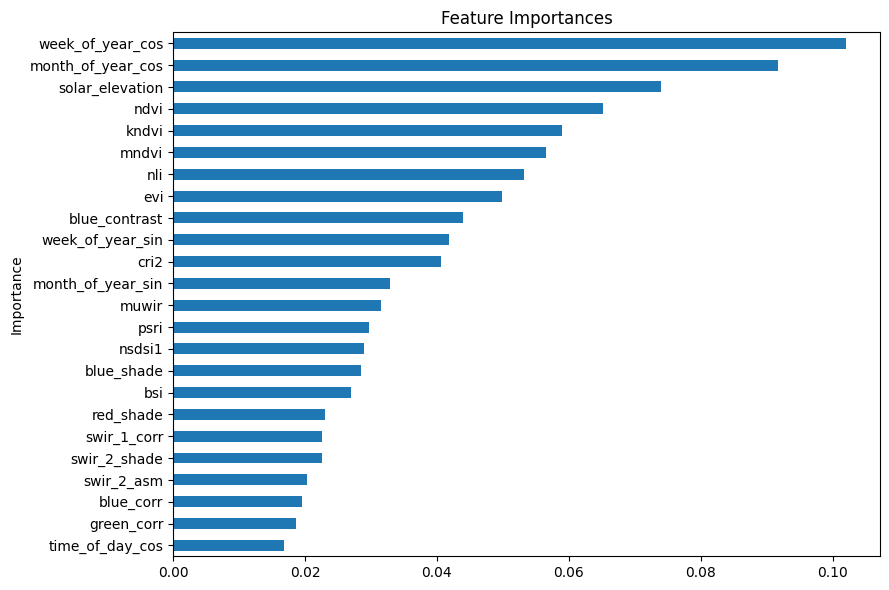

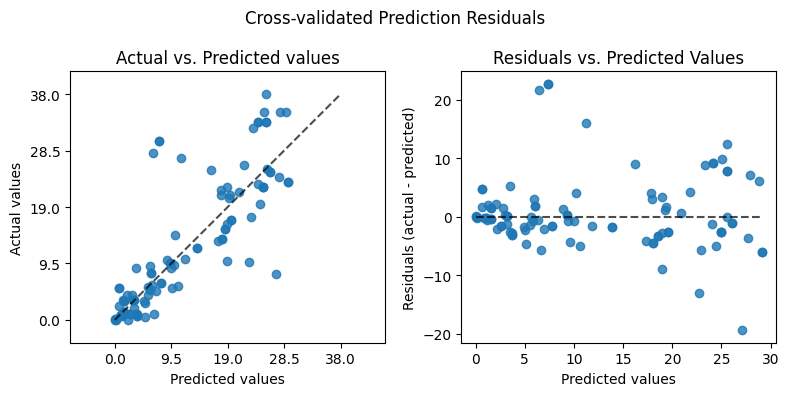

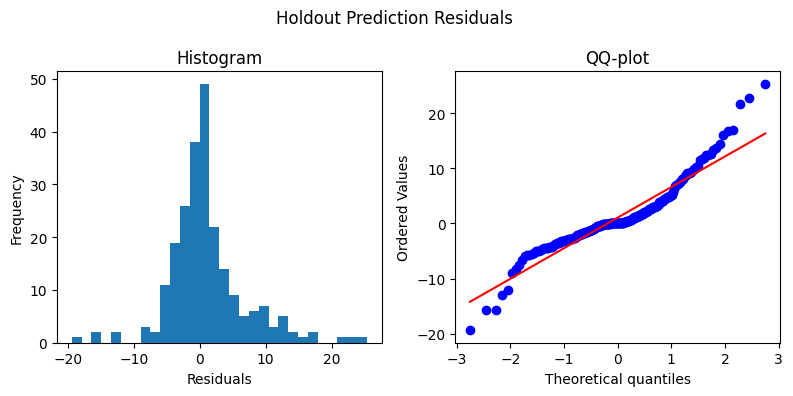

Note: the final valdiation (orange) mae score is from a cv training (i.e. training on small partitions of data). This cannot be compared to the actual mae score calculated from the holdout test set.


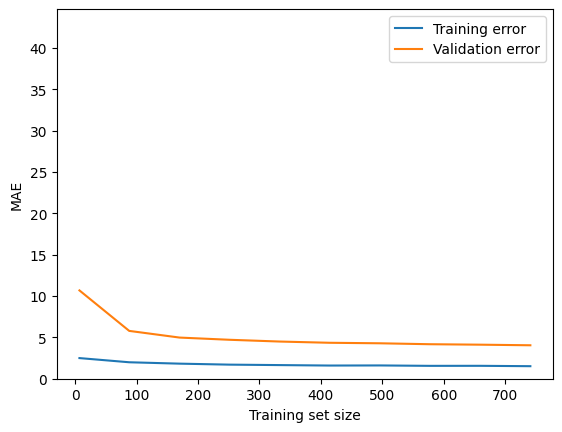

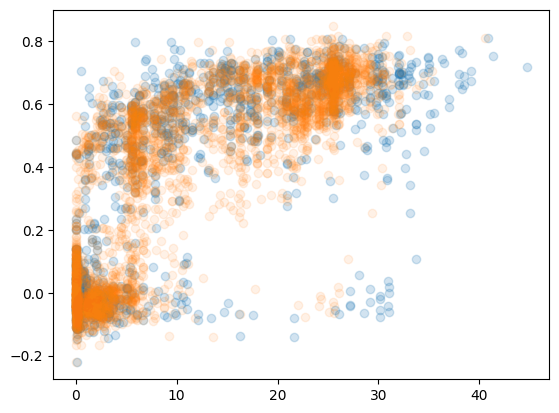

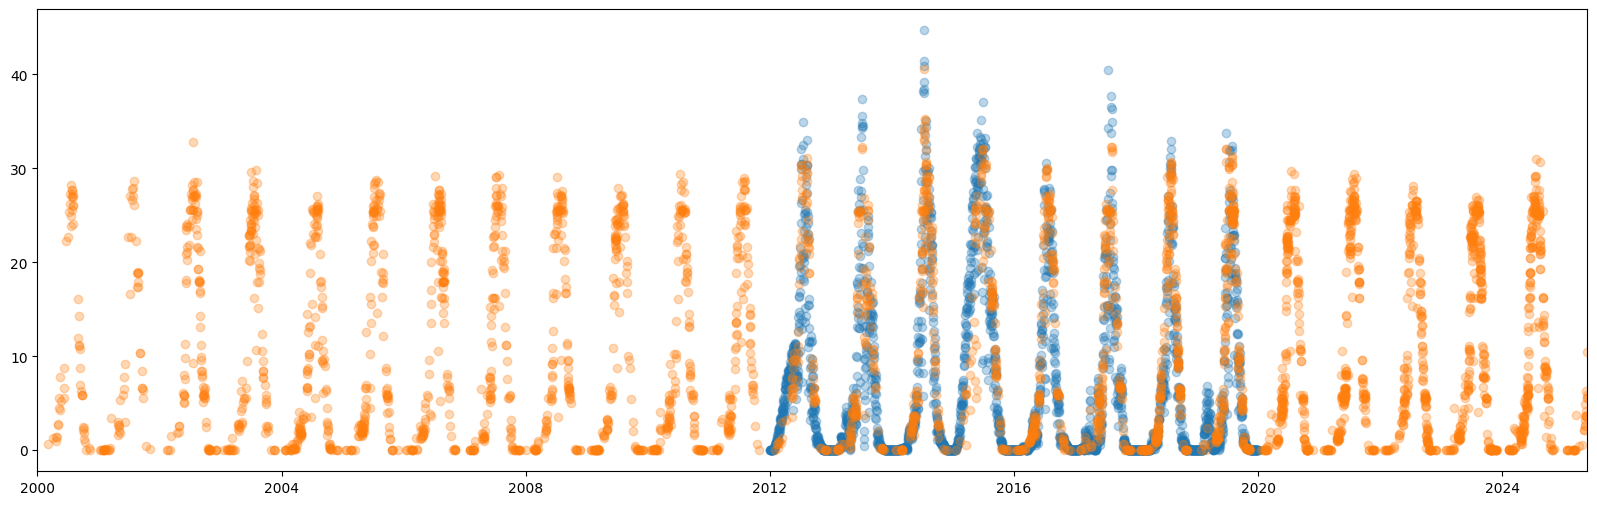

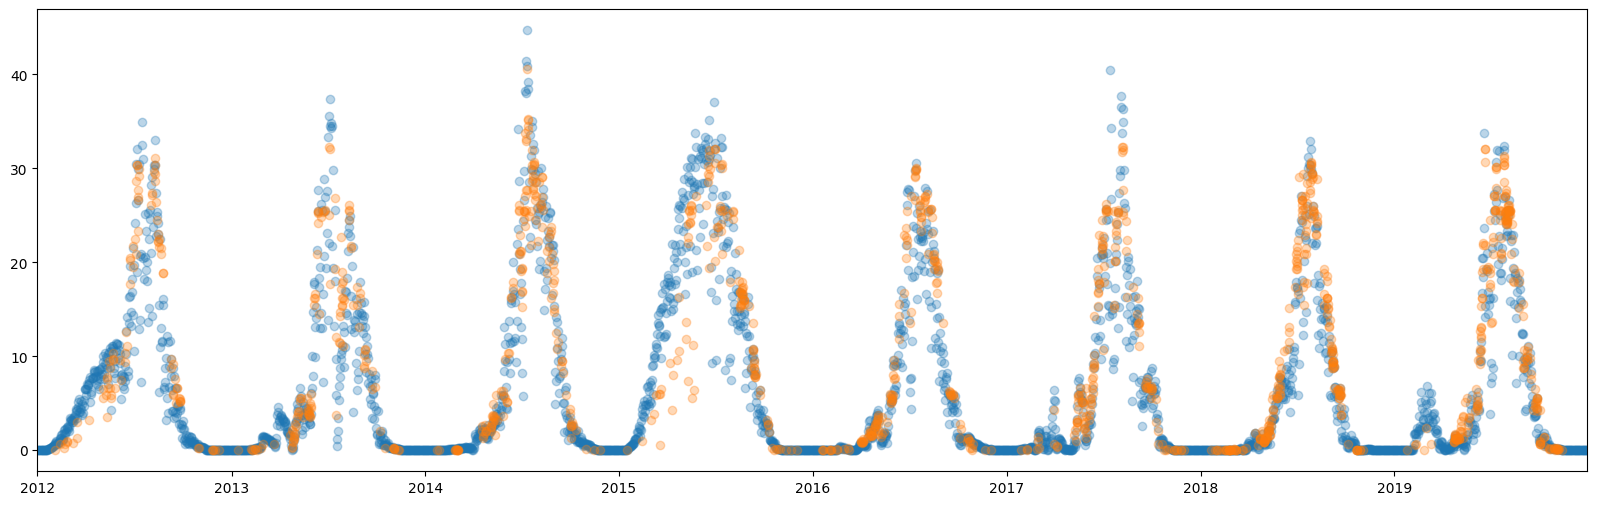

In [19]:
# Predict Against Test Data
y_pred_test = pipeline.predict(X_test)
# y_test, y_pred_test = filter_low_values(X_test, y_test, y_pred_test) # filter y_test and y_pred_test, removing low values that play havoc with evaluation and percentage error. Use ndvi >0.1 as per beaver et al.
evaluate(y_test, y_pred_test, pipeline, X_train, y_train, tsscv = 2) # setting tsscv to lower as there isn#t really enough data for 5!
#cv_score(pipeline, X_train, y_train, tsscv) # basically a fancy r2 that takes ages
#permute_pval(pipeline, X_test, y_test, 200, tsscv, seed) # Will use but takes ages (200 repeats = 90 mins)

# Apply
y_pred_unseen = pipeline.predict(df_unseen)
plot_test_model(data, site, predicted = y_pred_unseen)

In [20]:
with open(f"models/test/{site}_pipeline_{datetime.today().strftime('%Y-%m-%d')}.pkl", 'wb') as f:
        pickle.dump(pipeline, f)

## Abisko-Stordalen Palsa Bog (se_sto)

In [ ]:
# Site Data
site = "se_sto"
df_train = data[site].training.copy()
df_unseen = data[site].satellite.drop(columns = drop_cols, errors = "ignore").copy()

# Instantiate Training Stuff
X_train, X_test, y_train, y_test = prep_training_test_data(df_train, target_feature, holdout_perc, seed)
model = prep_training_test_model(possible_hyperparameters, tsscv, seed)
pipeline = construct_test_pipeline(model, X_train, categorical_features, tsscv, seed)

# Train
pipeline.fit(X_train, y_train)

c:\Users\Laurie\Files\Education\Postgraduate Degree\Modules\GEOGM0062 Dissertation MSc Climate Change Science and Policy\Processing and Analysis\arctic-ecosystems\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (577). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Laurie\Files\Education\Postgraduate Degree\Modules\GEOGM0062 Dissertation MSc Climate Change Science and Policy\Processing and Analysis\arctic-ecosystems\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (577). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  []),
                                                 ('num', StandardScaler(),
                                                  Index(['blue', 'blue_asm', 'blue_contrast', 'blue_corr', 'blue_dent',
       'blue_diss', 'blue_dvar', 'blue_ent', 'blue_idm', 'blue_imcorr1',
       ...
       'nsdsi3', 'bsmi', 'ndpi', 'nbr2', 'time_of_day_sin', 'tim...
                                                                         n_jobs=-1,
                                                                         param_distributions={'bootstrap': [True],
                                                                                              'max_depth': [None,
                                                                                                            10,
                                                                                                            20,
                                                                                                            30,
                                                                                                            50],
                                                                                              'max_features': [0.1,
                                                                                                               0.3,
                                                                                                               0.5,
                                                                                                               0.7,
                                                                                                               0.9,
                                                                                                               'sqrt',
                                                                                                               'log2'],
                                                                                              'min_samples_leaf': [1,
                                                                                                                   2,
                                                                                                                   4],
                                                                                              'min_samples_split': [2,
                                                                                                                    5,
                                                                                                                    10],
                                                                                              'n_estimators': [100,
                                                                                                               200,
                                                                                                               300,
                                                                                                               500,
                                                                                                               1000]},
                                                                         random_state=2,
                                                                         scoring='neg_mean_absolute_error'),
                                            transformer=QuantileTransformer(output_distribution='normal',
                                                                           

Best Hyperparameters:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 30,
 'max_features': 0.9,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}


Model Performance on Test Split
Mean Absolute Error (MAE): 1.2512775001178849
Mean Squared Error (MSE): 4.8067694832210375
Root Mean Squared Error (RMSE): 2.1924346018116565
Normalized MAE (as % of mean): 17.95%
Mean Absolute Percentage Error (MAPE): 0.46265922684674154
R-squared (R²): 0.8876


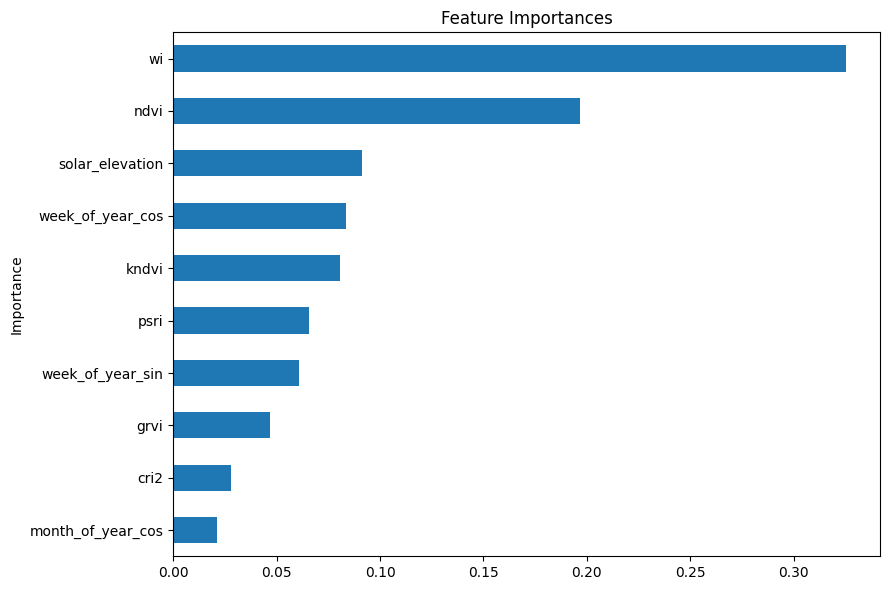

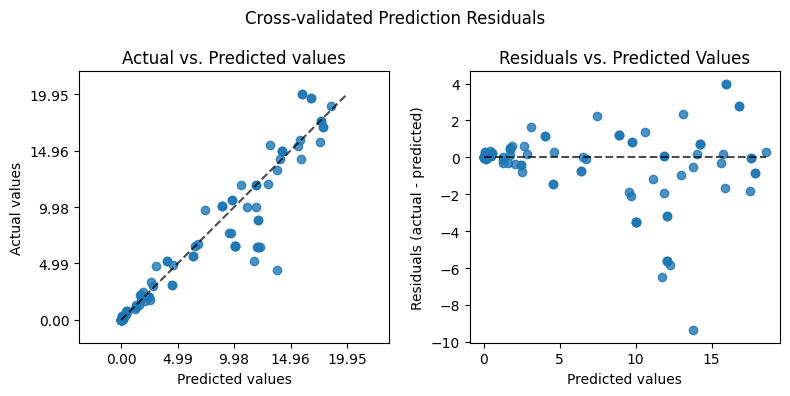

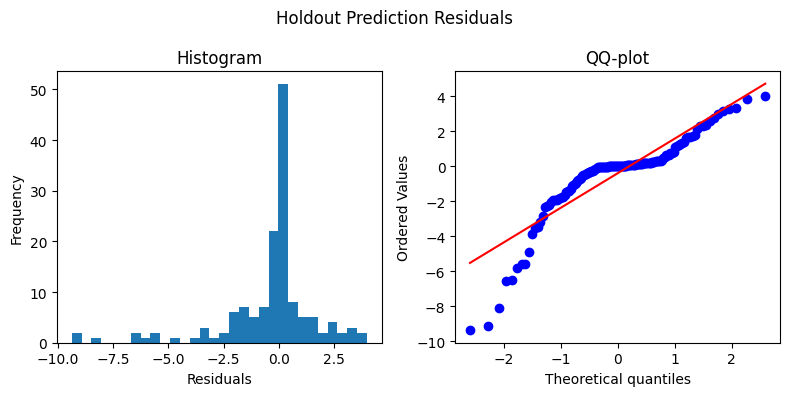

Note: the final valdiation (orange) mae score is from a cv training (i.e. training on small partitions of data). This cannot be compared to the actual mae score calculated from the holdout test set.


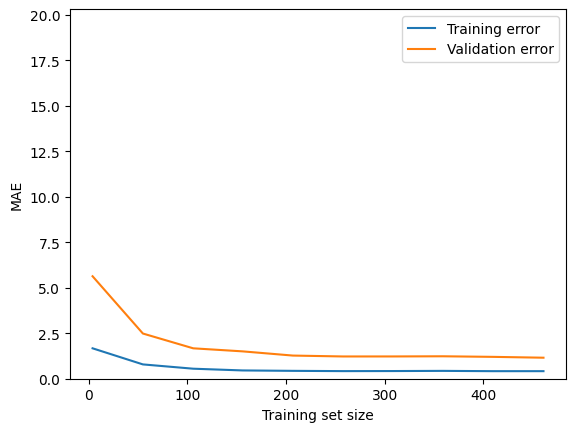

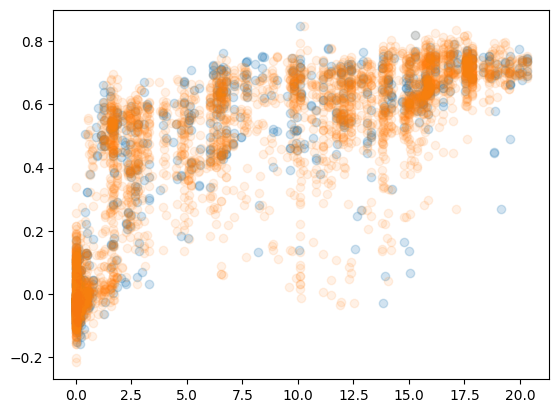

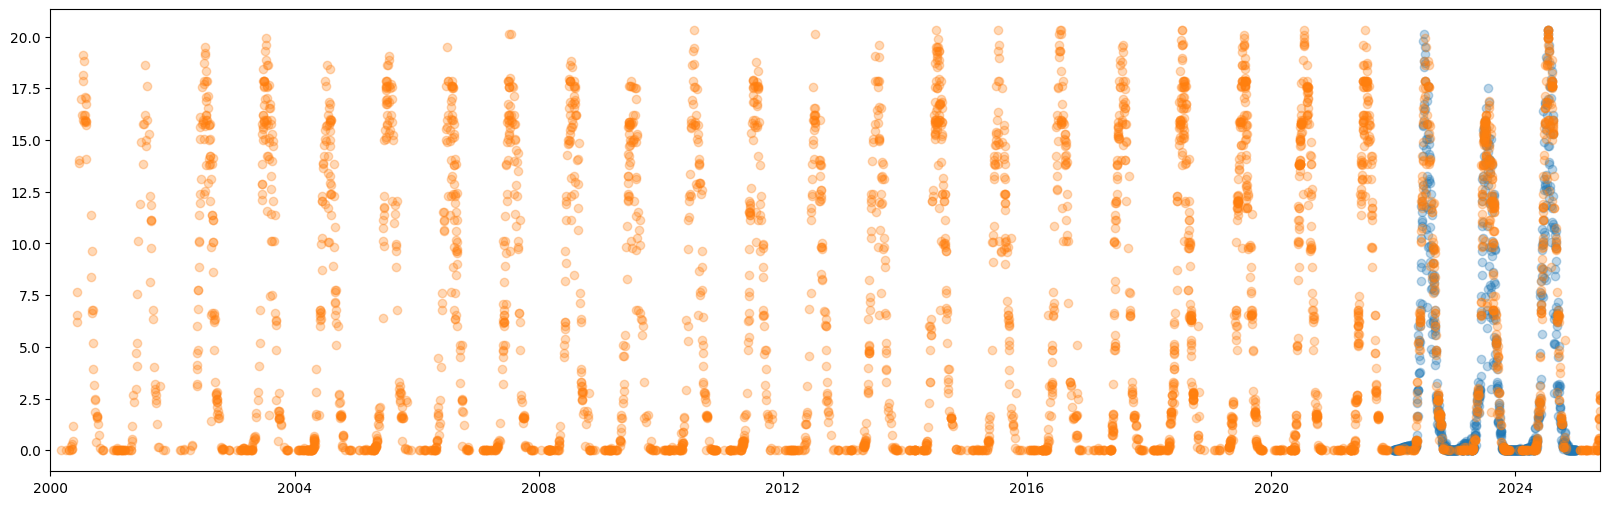

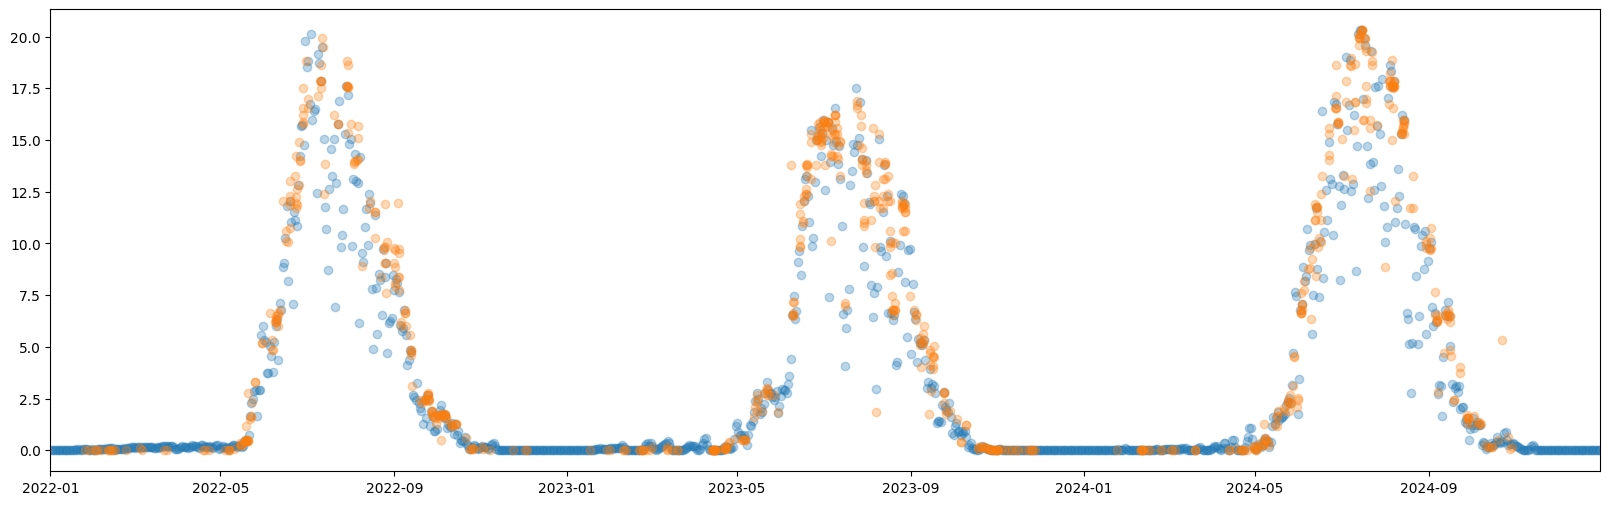

In [24]:
# Predict Against Test Data
y_pred_test = pipeline.predict(X_test)
# y_test, y_pred_test = filter_low_values(X_test, y_test, y_pred_test) # filter y_test and y_pred_test, removing low values that play havoc with evaluation and percentage error. Use ndvi >0.1 as per beaver et al.
evaluate(y_test, y_pred_test, pipeline, X_train, y_train, tsscv = 2) # setting tsscv to lower as there isn#t really enough data for 5!
#cv_score(pipeline, X_train, y_train, tsscv) # basically a fancy r2 that takes ages
#permute_pval(pipeline, X_test, y_test, 200, tsscv, seed) # Will use but takes ages (200 repeats = 90 mins)

# Apply
y_pred_unseen = pipeline.predict(df_unseen)
plot_test_model(data, site, predicted = y_pred_unseen)

In [25]:
with open(f"models/test/{site}_pipeline_{datetime.today().strftime('%Y-%m-%d')}.pkl", 'wb') as f:
        pickle.dump(pipeline, f)

## Kenttärova (fi_ken)

In [ ]:
# Site Data
site = "fi_ken"
df_train = data[site].training.copy()
df_unseen = data[site].satellite.drop(columns = drop_cols, errors = "ignore").copy()

# Instantiate Training Stuff
X_train, X_test, y_train, y_test = prep_training_test_data(df_train, target_feature, holdout_perc, seed)
model = prep_training_test_model(possible_hyperparameters, tsscv, seed)
pipeline = construct_test_pipeline(model, X_train, categorical_features, tsscv, seed)

# Train
pipeline.fit(X_train, y_train)

c:\Users\Laurie\Files\Education\Postgraduate Degree\Modules\GEOGM0062 Dissertation MSc Climate Change Science and Policy\Processing and Analysis\arctic-ecosystems\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (604). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Laurie\Files\Education\Postgraduate Degree\Modules\GEOGM0062 Dissertation MSc Climate Change Science and Policy\Processing and Analysis\arctic-ecosystems\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (604). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  []),
                                                 ('num', StandardScaler(),
                                                  Index(['blue', 'blue_asm', 'blue_contrast', 'blue_corr', 'blue_dent',
       'blue_diss', 'blue_dvar', 'blue_ent', 'blue_idm', 'blue_imcorr1',
       ...
       'nsdsi3', 'bsmi', 'ndpi', 'nbr2', 'time_of_day_sin', 'tim...
                                                                         n_jobs=-1,
                                                                         param_distributions={'bootstrap': [True],
                                                                                              'max_depth': [None,
                                                                                                            10,
                                                                                                            20,
                                                                                                            30,
                                                                                                            50],
                                                                                              'max_features': [0.1,
                                                                                                               0.3,
                                                                                                               0.5,
                                                                                                               0.7,
                                                                                                               0.9,
                                                                                                               'sqrt',
                                                                                                               'log2'],
                                                                                              'min_samples_leaf': [1,
                                                                                                                   2,
                                                                                                                   4],
                                                                                              'min_samples_split': [2,
                                                                                                                    5,
                                                                                                                    10],
                                                                                              'n_estimators': [100,
                                                                                                               200,
                                                                                                               300,
                                                                                                               500,
                                                                                                               1000]},
                                                                         random_state=2,
                                                                         scoring='neg_mean_absolute_error'),
                                            transformer=QuantileTransformer(output_distribution='normal',
                                                                           

Best Hyperparameters:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 50,
 'max_features': 0.3,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 200,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}


Model Performance on Test Split
Mean Absolute Error (MAE): 4.525936541621139
Mean Squared Error (MSE): 48.046326052680826
Root Mean Squared Error (RMSE): 6.931545718862484
Normalized MAE (as % of mean): 24.72%
Mean Absolute Percentage Error (MAPE): 0.4282783678399962
R-squared (R²): 0.7444


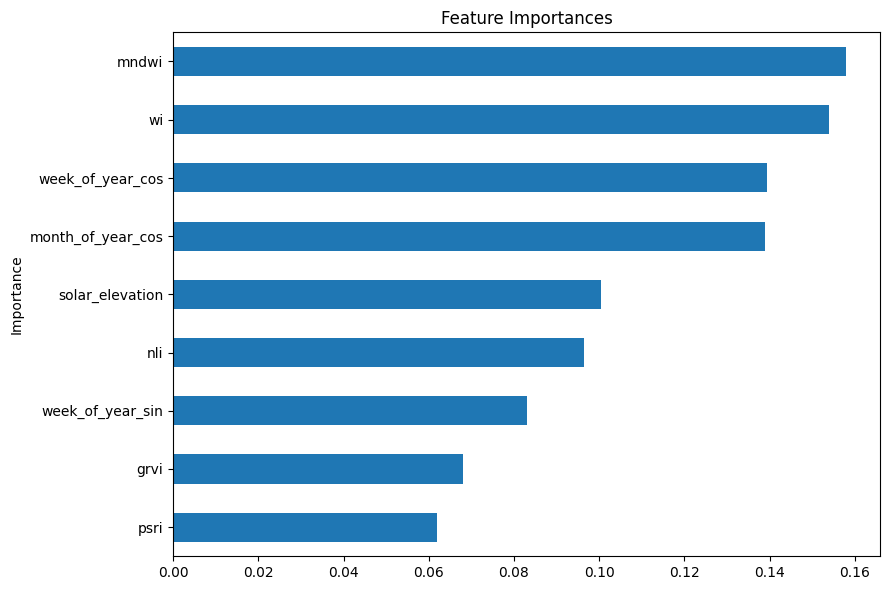

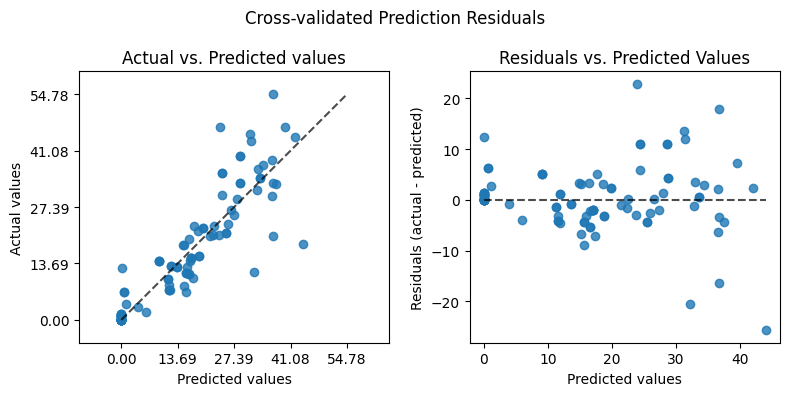

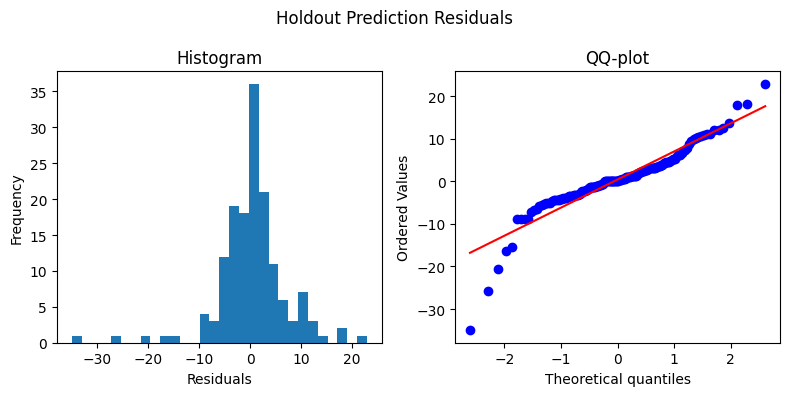

Note: the final valdiation (orange) mae score is from a cv training (i.e. training on small partitions of data). This cannot be compared to the actual mae score calculated from the holdout test set.


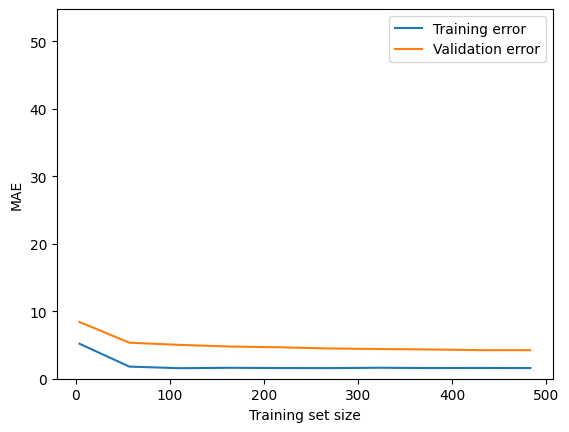

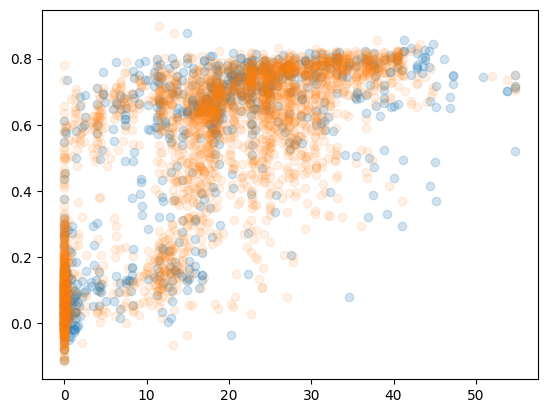

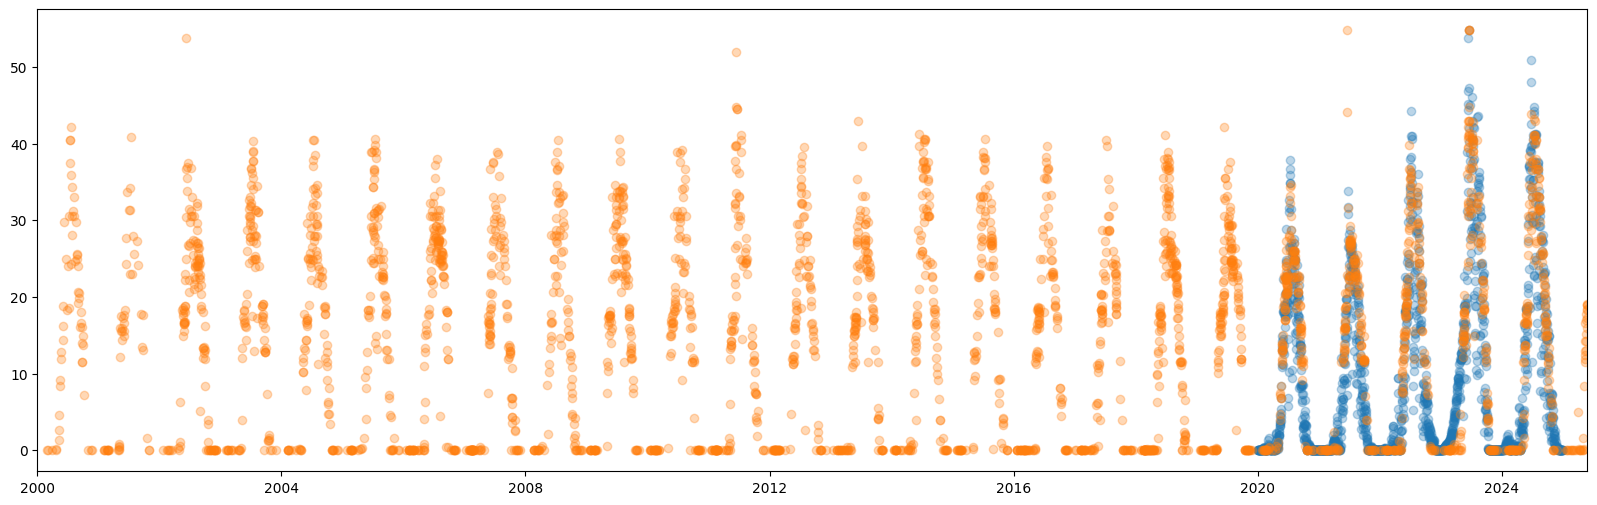

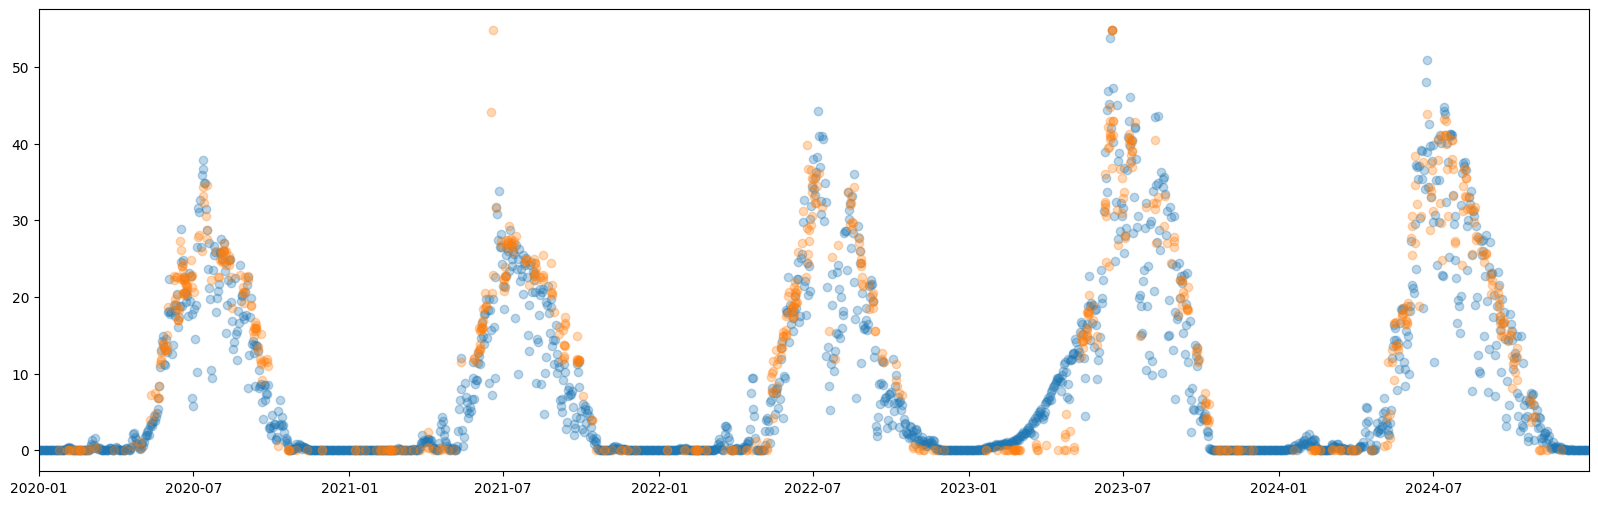

In [27]:
# Predict Against Test Data
y_pred_test = pipeline.predict(X_test)
# y_test, y_pred_test = filter_low_values(X_test, y_test, y_pred_test) # filter y_test and y_pred_test, removing low values that play havoc with evaluation and percentage error. Use ndvi >0.1 as per beaver et al.
evaluate(y_test, y_pred_test, pipeline, X_train, y_train, tsscv = 2) # setting tsscv to lower as there isn#t really enough data for 5!
#cv_score(pipeline, X_train, y_train, tsscv) # basically a fancy r2 that takes ages
#permute_pval(pipeline, X_test, y_test, 200, tsscv, seed) # Will use but takes ages (200 repeats = 90 mins)

# Apply
y_pred_unseen = pipeline.predict(df_unseen)
plot_test_model(data, site, predicted = y_pred_unseen)

In [28]:
with open(f"models/test/{site}_pipeline_{datetime.today().strftime('%Y-%m-%d')}.pkl", 'wb') as f:
        pickle.dump(pipeline, f)

## Sodankyla (fi_sod)

In [ ]:
# Site Data
site = "fi_sod"
df_train = data[site].training.copy()
df_unseen = data[site].satellite.drop(columns = drop_cols, errors = "ignore").copy()

# Instantiate Training Stuff
X_train, X_test, y_train, y_test = prep_training_test_data(df_train, target_feature, holdout_perc, seed)
model = prep_training_test_model(possible_hyperparameters, tsscv, seed)
pipeline = construct_test_pipeline(model, X_train, categorical_features, tsscv, seed)

# Train
pipeline.fit(X_train, y_train)

c:\Users\Laurie\Files\Education\Postgraduate Degree\Modules\GEOGM0062 Dissertation MSc Climate Change Science and Policy\Processing and Analysis\arctic-ecosystems\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (331). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Laurie\Files\Education\Postgraduate Degree\Modules\GEOGM0062 Dissertation MSc Climate Change Science and Policy\Processing and Analysis\arctic-ecosystems\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (331). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  []),
                                                 ('num', StandardScaler(),
                                                  Index(['blue', 'blue_asm', 'blue_contrast', 'blue_corr', 'blue_dent',
       'blue_diss', 'blue_dvar', 'blue_ent', 'blue_idm', 'blue_imcorr1',
       ...
       'nsdsi3', 'bsmi', 'ndpi', 'nbr2', 'time_of_day_sin', 'tim...
                                                                         n_jobs=-1,
                                                                         param_distributions={'bootstrap': [True],
                                                                                              'max_depth': [None,
                                                                                                            10,
                                                                                                            20,
                                                                                                            30,
                                                                                                            50],
                                                                                              'max_features': [0.1,
                                                                                                               0.3,
                                                                                                               0.5,
                                                                                                               0.7,
                                                                                                               0.9,
                                                                                                               'sqrt',
                                                                                                               'log2'],
                                                                                              'min_samples_leaf': [1,
                                                                                                                   2,
                                                                                                                   4],
                                                                                              'min_samples_split': [2,
                                                                                                                    5,
                                                                                                                    10],
                                                                                              'n_estimators': [100,
                                                                                                               200,
                                                                                                               300,
                                                                                                               500,
                                                                                                               1000]},
                                                                         random_state=2,
                                                                         scoring='neg_mean_absolute_error'),
                                            transformer=QuantileTransformer(output_distribution='normal',
                                                                           

Best Hyperparameters:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 30,
 'max_features': 0.1,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 200,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}


Model Performance on Test Split
Mean Absolute Error (MAE): 3.6903081676202314
Mean Squared Error (MSE): 22.49615802885847
Root Mean Squared Error (RMSE): 4.743011493646043
Normalized MAE (as % of mean): 27.19%
Mean Absolute Percentage Error (MAPE): 13772499722508.518
R-squared (R²): 0.7756


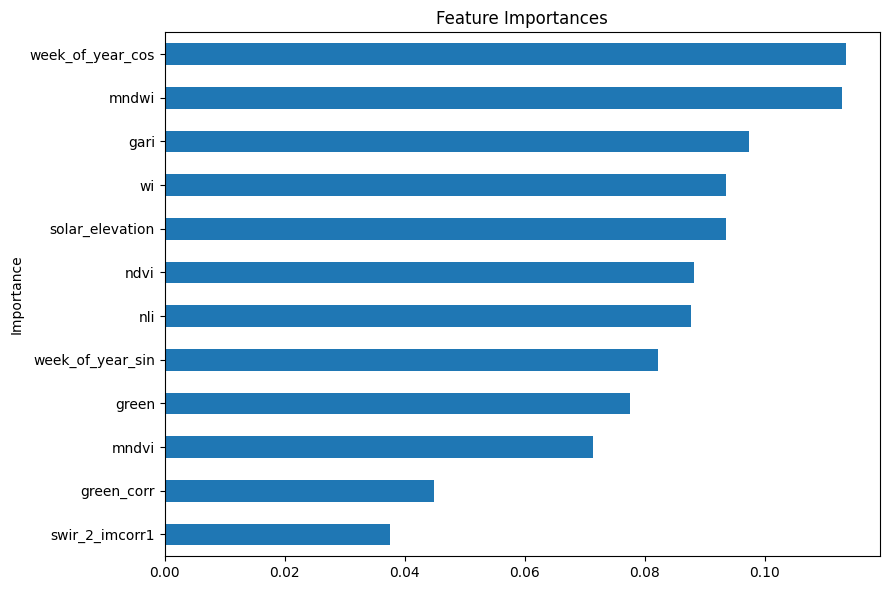

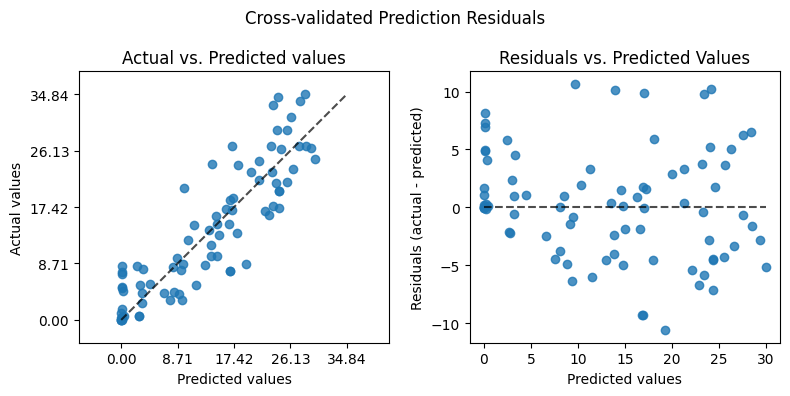

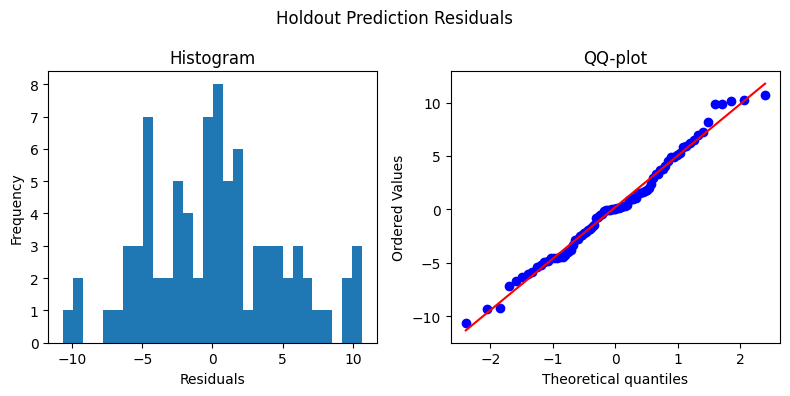

Note: the final valdiation (orange) mae score is from a cv training (i.e. training on small partitions of data). This cannot be compared to the actual mae score calculated from the holdout test set.


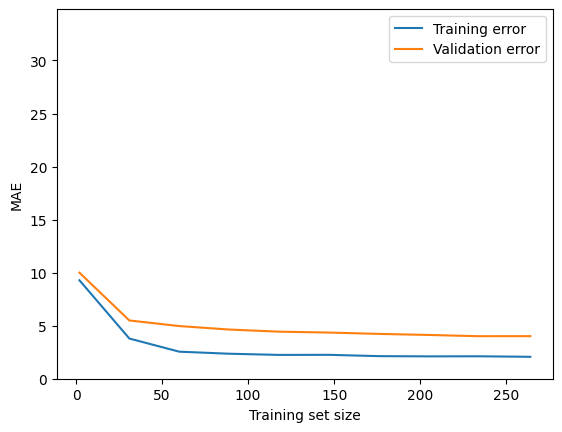

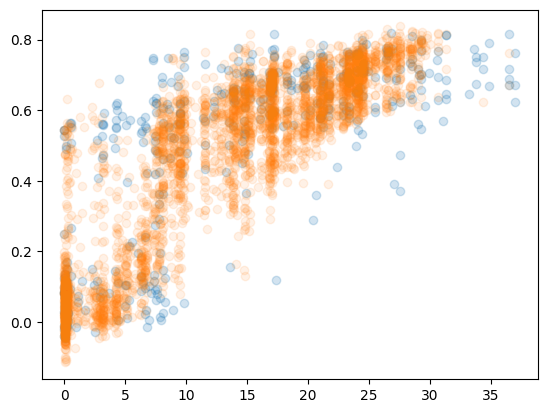

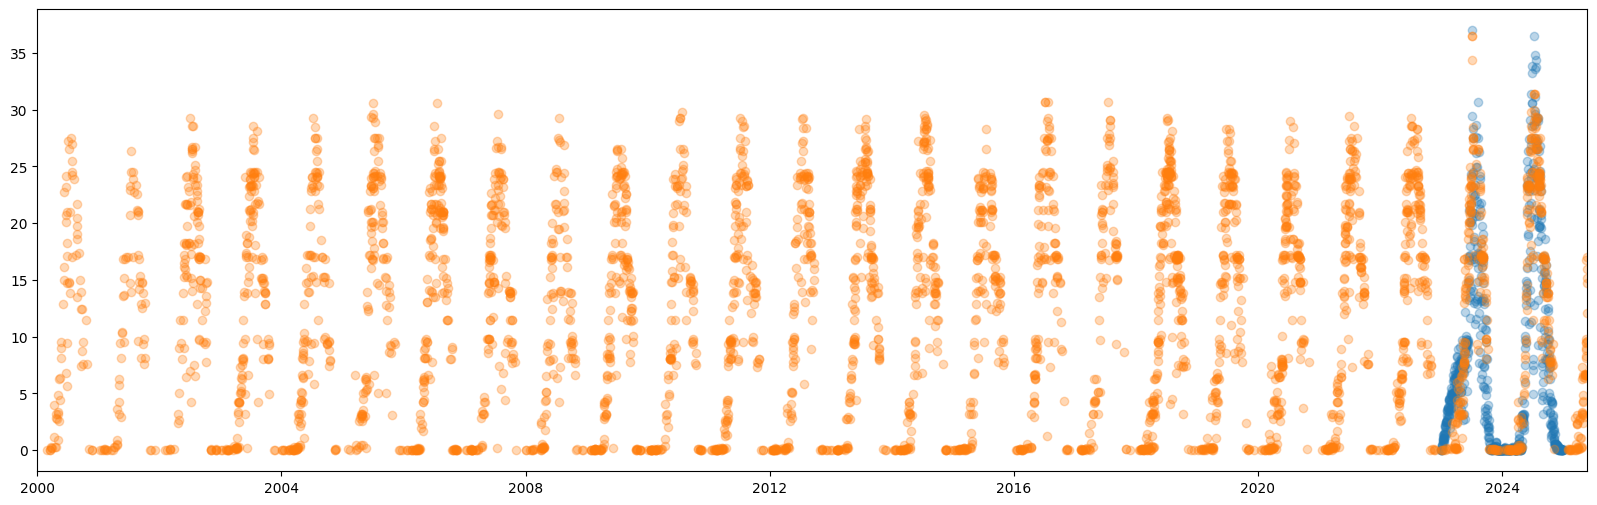

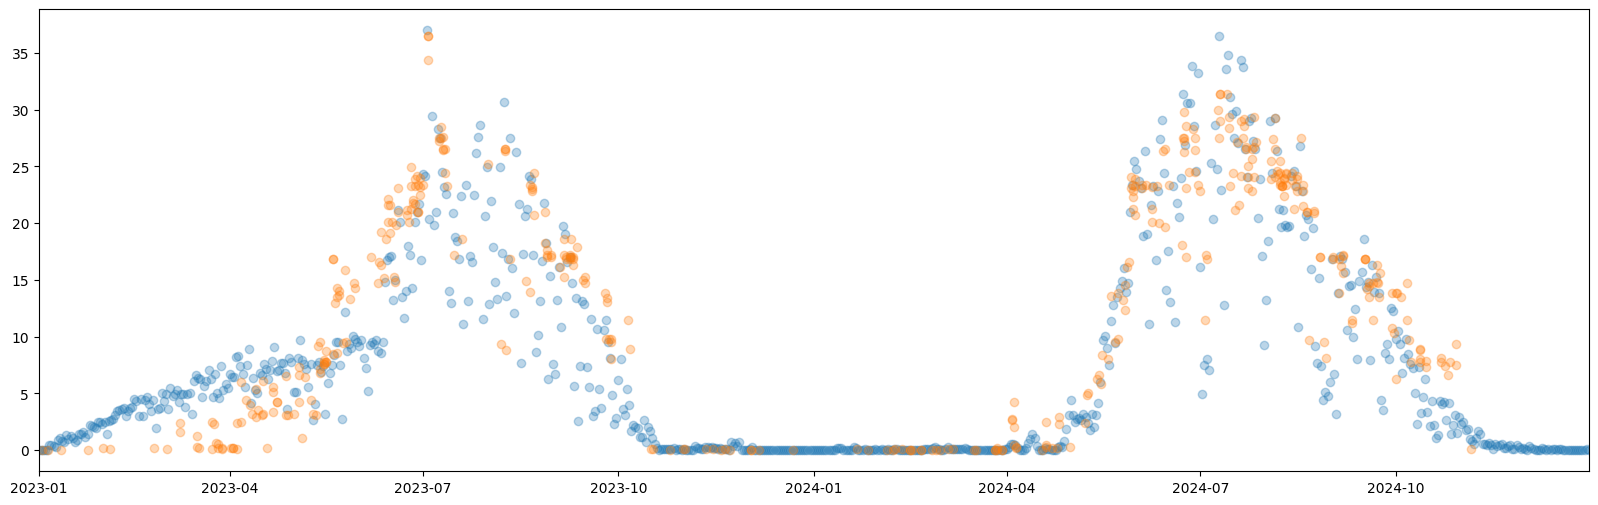

In [30]:
# Predict Against Test Data
y_pred_test = pipeline.predict(X_test)
# y_test, y_pred_test = filter_low_values(X_test, y_test, y_pred_test) # filter y_test and y_pred_test, removing low values that play havoc with evaluation and percentage error. Use ndvi >0.1 as per beaver et al.
evaluate(y_test, y_pred_test, pipeline, X_train, y_train, tsscv = 2) # setting tsscv to lower as there isn#t really enough data for 5!
#cv_score(pipeline, X_train, y_train, tsscv) # basically a fancy r2 that takes ages
#permute_pval(pipeline, X_test, y_test, 200, tsscv, seed) # Will use but takes ages (200 repeats = 90 mins)

# Apply
y_pred_unseen = pipeline.predict(df_unseen)
plot_test_model(data, site, predicted = y_pred_unseen)

In [31]:
with open(f"models/test/{site}_pipeline_{datetime.today().strftime('%Y-%m-%d')}.pkl", 'wb') as f:
        pickle.dump(pipeline, f)

## Varrio (fi_var)

In [24]:
# Site Data
site = "fi_var"
df_train = data[site].training.copy()
df_unseen = data[site].satellite.drop(columns = drop_cols, errors = "ignore").copy()

# Instantiate Training Stuff
X_train, X_test, y_train, y_test = prep_training_test_data(df_train, target_feature, holdout_perc, seed)
model = prep_training_test_model(possible_hyperparameters, tsscv, seed)
pipeline = construct_test_pipeline(model, X_train, categorical_features, tsscv, seed)

# Train
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  []),
                                                 ('num', StandardScaler(),
                                                  Index(['blue', 'blue_asm', 'blue_contrast', 'blue_corr', 'blue_dent',
       'blue_diss', 'blue_dvar', 'blue_ent', 'blue_idm', 'blue_imcorr1',
       ...
       'nsdsi3', 'bsmi', 'ndpi', 'nbr2', 'time_of_day_sin', 'tim...
                                                                         n_jobs=-1,
                                                                         param_distributions={'bootstrap': [True],
                                                                                              'max_depth': [None,
                                                                                                            10,
                                                                                                            20,
                                                                                                            30,
                                                                                                            50],
                                                                                              'max_features': [0.1,
                                                                                                               0.3,
                                                                                                               0.5,
                                                                                                               0.7,
                                                                                                               0.9,
                                                                                                               'sqrt',
                                                                                                               'log2'],
                                                                                              'min_samples_leaf': [1,
                                                                                                                   2,
                                                                                                                   4],
                                                                                              'min_samples_split': [2,
                                                                                                                    5,
                                                                                                                    10],
                                                                                              'n_estimators': [100,
                                                                                                               200,
                                                                                                               300,
                                                                                                               500,
                                                                                                               1000]},
                                                                         random_state=2,
                                                                         scoring='neg_mean_absolute_error'),
                                            transformer=QuantileTransformer(output_distribution='normal',
                                                                           

Best Hyperparameters:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 50,
 'max_features': 0.1,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}


Model Performance on Test Split
Mean Absolute Error (MAE): 2.80452332456956
Mean Squared Error (MSE): 16.40904607398904
Root Mean Squared Error (RMSE): 4.050808076666807
Normalized MAE (as % of mean): 24.55%
Mean Absolute Percentage Error (MAPE): 0.5098844319196479
R-squared (R²): 0.7789


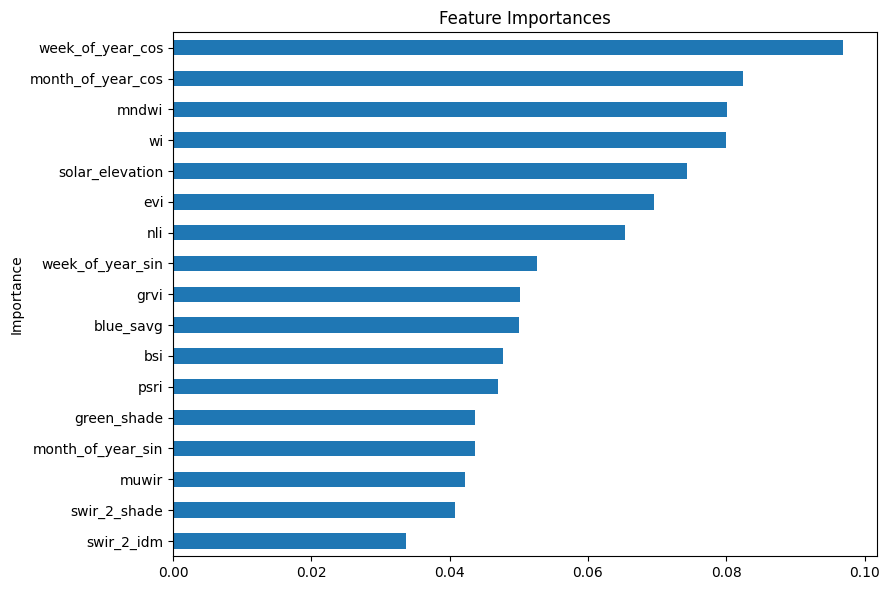

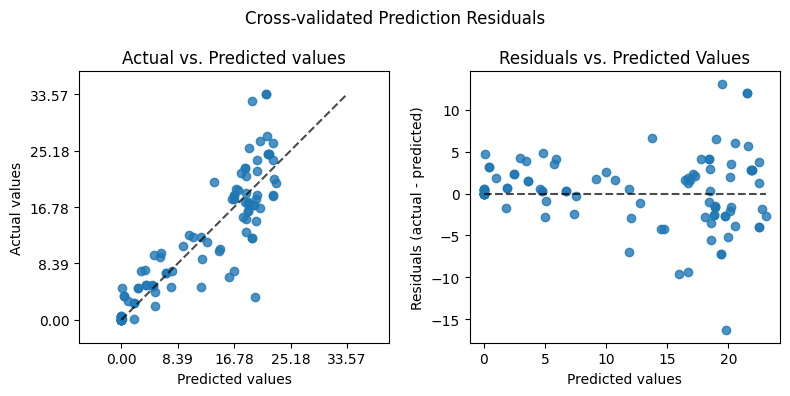

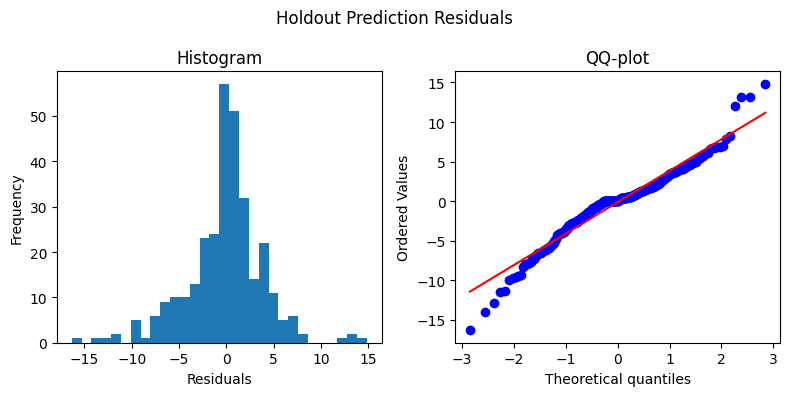

Note: the final valdiation (orange) mae score is from a cv training (i.e. training on small partitions of data). This cannot be compared to the actual mae score calculated from the holdout test set.


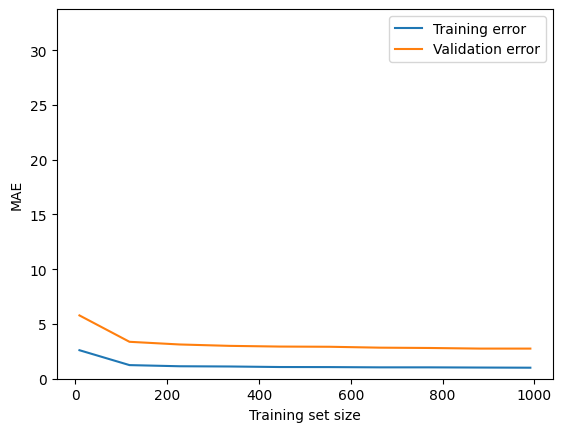

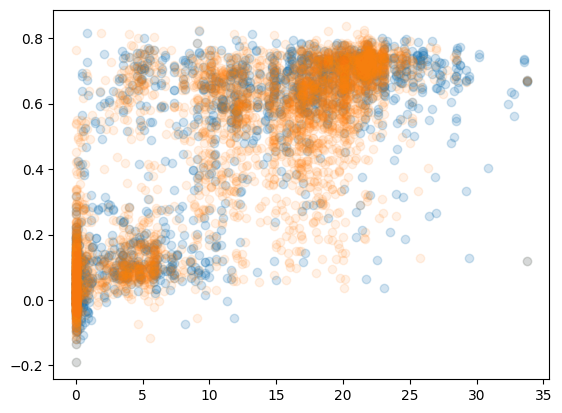

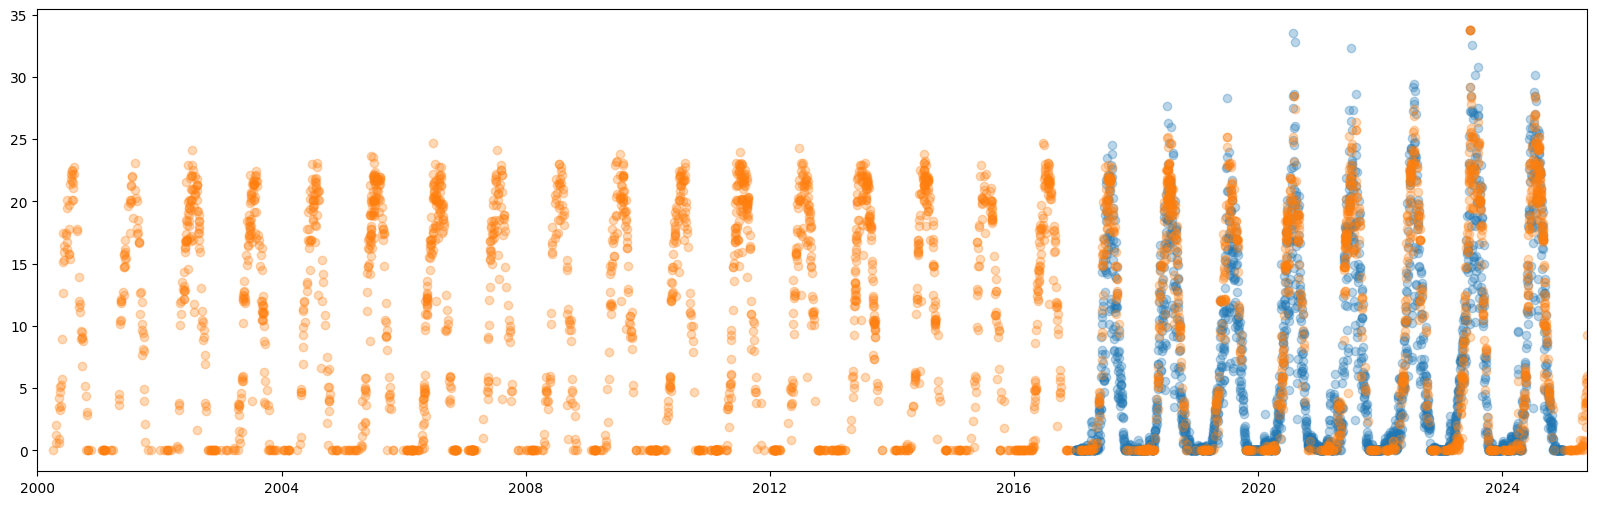

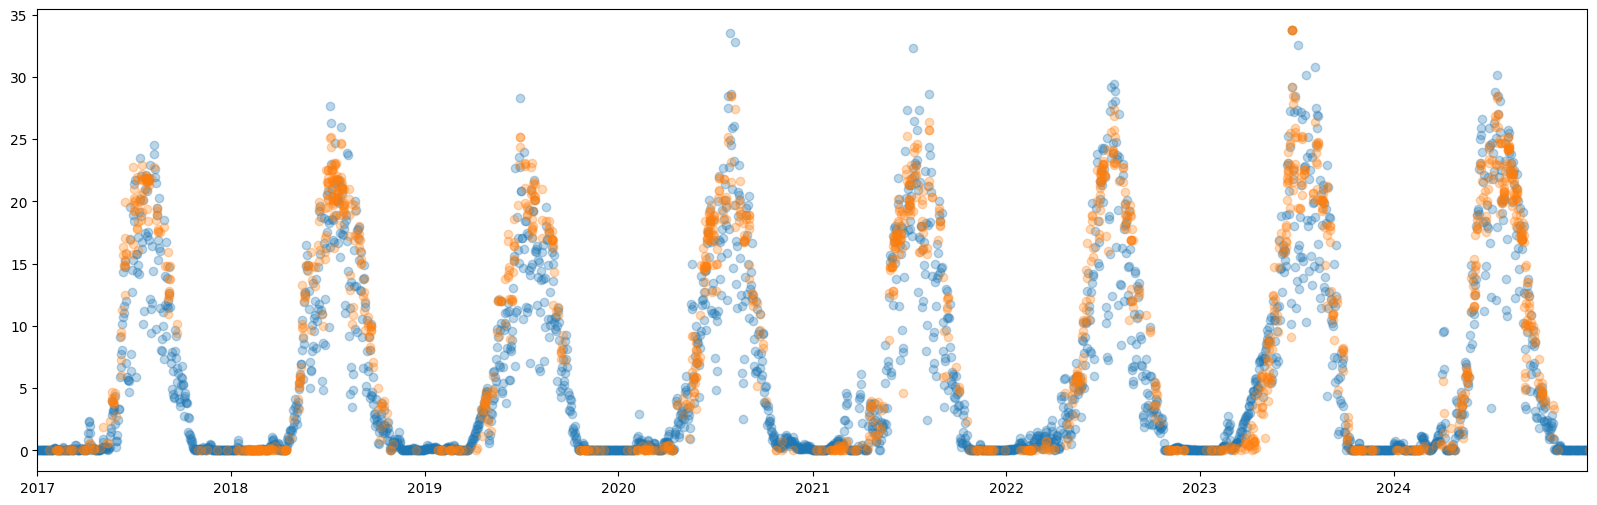

In [26]:
# Predict Against Test Data
y_pred_test = pipeline.predict(X_test)
# y_test, y_pred_test = filter_low_values(X_test, y_test, y_pred_test) # filter y_test and y_pred_test, removing low values that play havoc with evaluation and percentage error. Use ndvi >0.1 as per beaver et al.
evaluate(y_test, y_pred_test, pipeline, X_train, y_train, tsscv = 2) # setting tsscv to lower as there isn#t really enough data for 5!
#cv_score(pipeline, X_train, y_train, tsscv) # basically a fancy r2 that takes ages
#permute_pval(pipeline, X_test, y_test, 200, tsscv, seed) # Will use but takes ages (200 repeats = 90 mins)

# Apply
y_pred_unseen = pipeline.predict(df_unseen)
plot_test_model(data, site, predicted = y_pred_unseen)

In [27]:
with open(f"models/test/{site}_pipeline_{datetime.today().strftime('%Y-%m-%d')}.pkl", 'wb') as f:
        pickle.dump(pipeline, f)

# Train Final Models
Train final models on all the data using the best parameters from testing

In [60]:
pipelines = {}
for file in os.listdir("models/test/"):
    site = file.strip()[0:6]
    with open(f"models/test/{file}", 'rb') as f:
        pipelines[site] = pickle.load(f)

In [22]:
def get_final_features_from_pipeline(pipeline):
    
    # Get initial features after quantile transform step
    features = pipeline.named_steps['quantile'].get_feature_names_out()
    
    # Find all feature selection steps (names starting with "select") in order
    select_steps = [(name, step) for name, step in pipeline.named_steps.items() if name.startswith('select')]
    select_steps.sort(key=lambda x: list(pipeline.named_steps).index(x[0]))  # preserve pipeline order
    
    # Loop through all selectors and apply get_support mask
    for name, selector in select_steps:
        mask = selector.get_support()
        features = features[mask]
    
    # Clean feature names by stripping transformer prefixes
    clean_feature_names = [name.split("__")[-1] for name in features]
    
    return clean_feature_names

In [ ]:
target_feature = "gpp"
seed = 2
categorical_features = []

for site, pipeline in pipelines.items():
    
    hyperparameters = pipeline.named_steps["model"].regressor_.best_estimator_.get_params()
    features = get_final_features_from_pipeline(pipeline)
    
    df_train = data[site].training

    X_train, y_train = prep_training_full_data(df_train, target_feature)
    model = prep_training_full_model(hyperparameters, seed)
    pipeline = construct_full_pipeline(model, X_train, categorical_features, seed)
    pipeline.fit(X_train, y_train)

    with open(f"models/final/{site}_pipeline_{datetime.today().strftime('%Y-%m-%d')}.pkl", 'wb') as f:
        pickle.dump(pipeline, f)

c:\Users\Laurie\Files\Education\Postgraduate Degree\Modules\GEOGM0062 Dissertation MSc Climate Change Science and Policy\Processing and Analysis\arctic-ecosystems\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (756). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Laurie\Files\Education\Postgraduate Degree\Modules\GEOGM0062 Dissertation MSc Climate Change Science and Policy\Processing and Analysis\arctic-ecosystems\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (756). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Laurie\Files\Education\Postgraduate Degree\Modules\GEOGM0062 Dissertation MSc Climate Change Science and Policy\Processing and Analysis\arctic-ecosystems\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total numb

## Cross-site Evaluation
We can evaluate each model on every other site to get an idea of how well each model generalises to other sites and ecosystems

In [ ]:
pipelines = {}
for file in os.listdir("models/final/"):
    site = file.strip()[0:6]
    with open(f"models/final/{file}", 'rb') as f:
        pipelines[site] = pickle.load(f)

for site_source, pipeline in pipelines.items():
    for site_compare in data:
        y_pred_test = pipeline.predict(X_test)
        evaluate(y_test, y_pred_test, pipeline, X_train, y_train, tsscv = 2)

# Estimate GPP

In [3]:
pipelines = {}
for file in os.listdir("models/final/"):
    site = file.strip()[0:6]
    with open(f"models/final/{file}", 'rb') as f:
        pipelines[site] = pickle.load(f)

In [20]:
for site, pipeline in pipelines.items():
    data[site].satellite["gppe"] = pipeline.predict(data[site].satellite)
    data[site].satellite.to_csv(f"gppe/{site}_satellite-gppe{datetime.today().strftime('%Y-%m-%d')}")

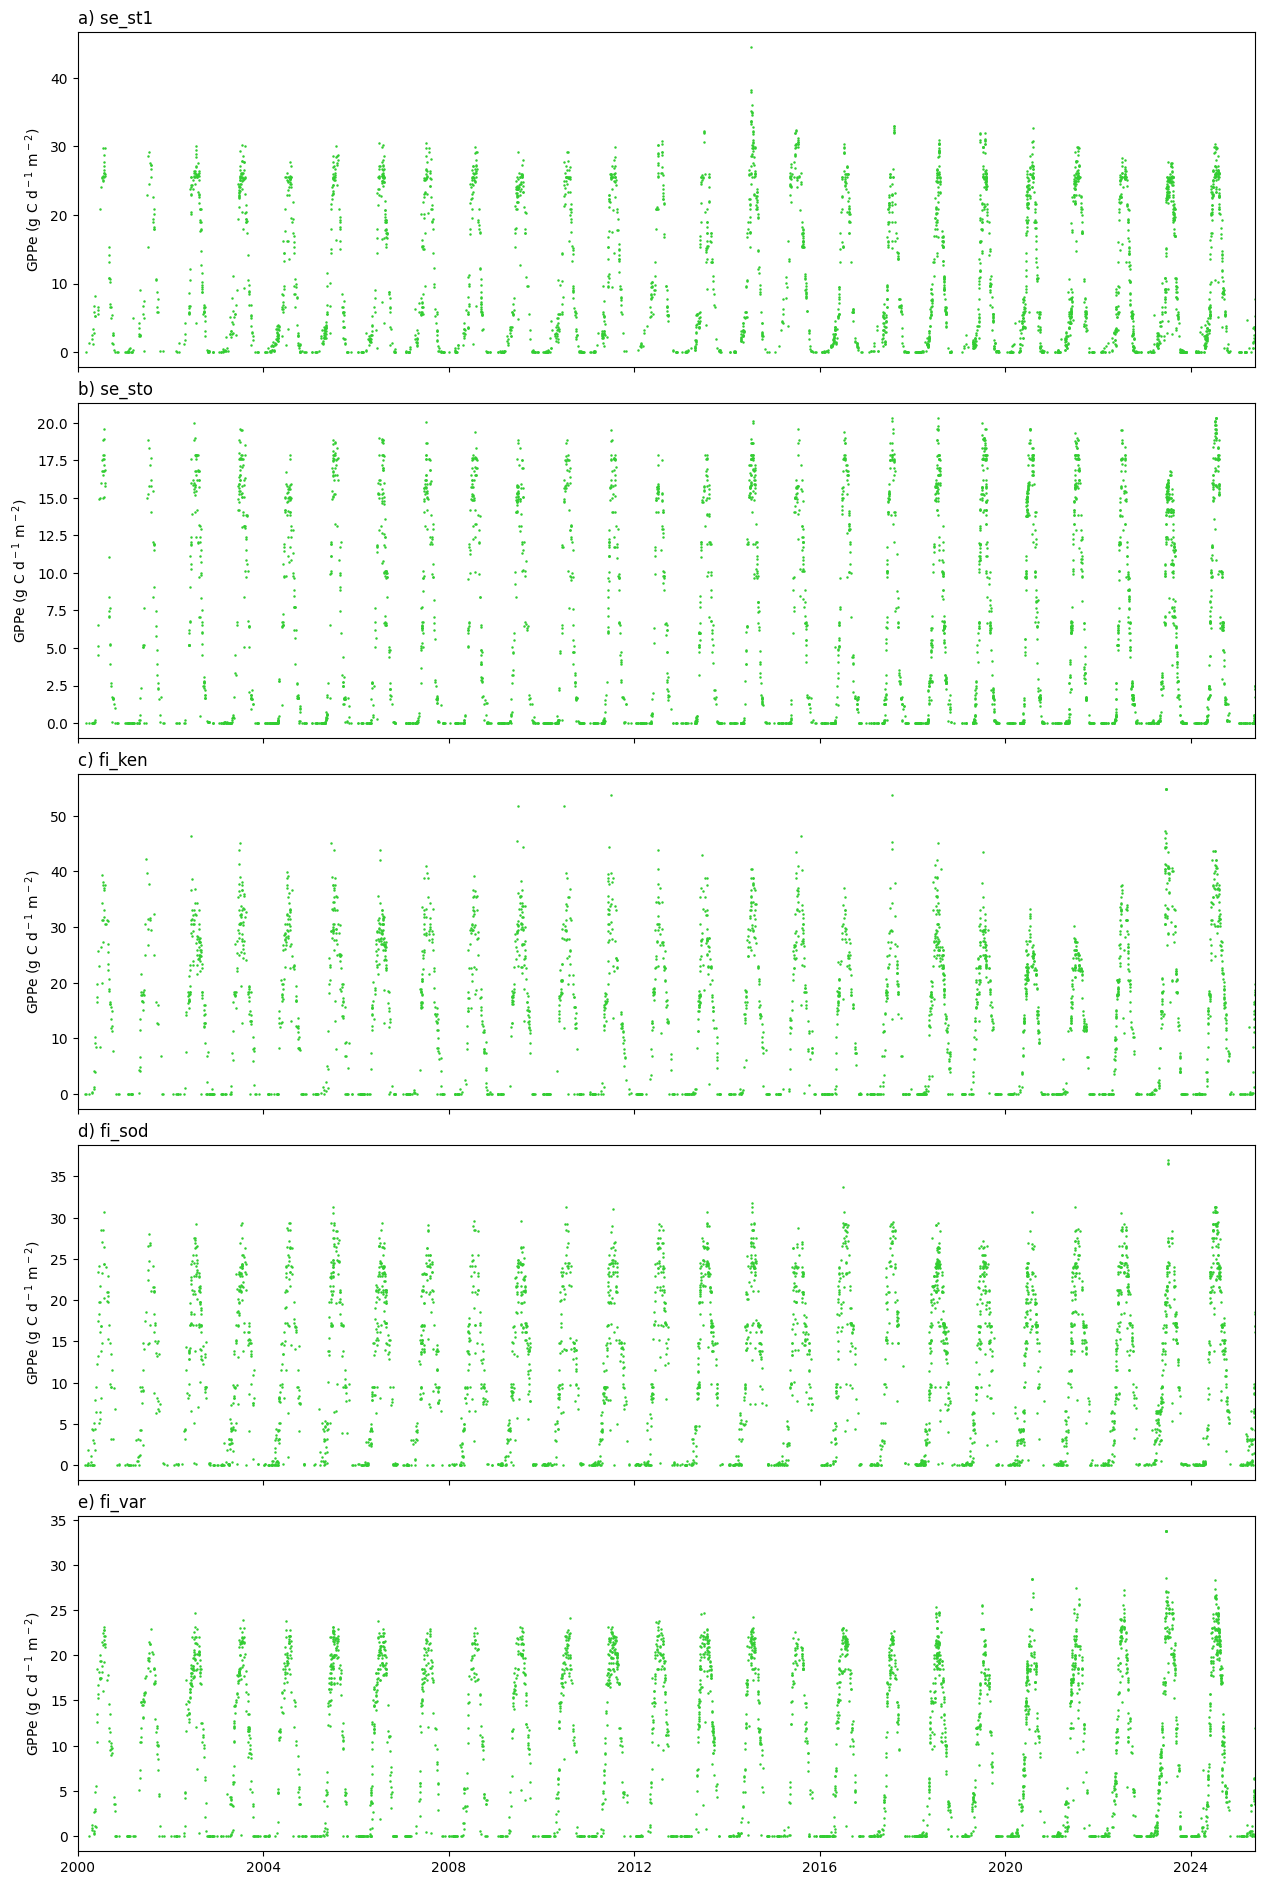

In [21]:
scaler = 2
fig_wide = 6.267717 * scaler # width of a4 minus 2.54cm margins either side then x by scaler to scale everything's size easily
fig_gold = 1.618
nrows = 5
ncols = 1
squish_factor = 20
fig, ax = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(fig_wide, (fig_wide / fig_gold) * ((nrows) / ncols) - squish_factor),
    sharex = True, constrained_layout = True
)
ax = ax.flatten()

def plot(ax_no):
    ax[ax_no].set_title(f"{chr(ord('`')+ax_no+1)}) {site}", loc = "left")
    ax[ax_no].scatter(data[site].satellite.index, data[site].satellite["gppe"], alpha = 1, s = 0.6, c = "limegreen")
    ax[ax_no].set_xlim(pd.Timestamp("2000-01-01"), df_satellite.index.max())
    ax[ax_no].set_ylabel("GPPe (g C d$^-$$^1$ m$^-$$^2$)")

for site, df in data.items():
    ax_no = list(data.keys()).index(site)
    plot(ax_no)

plt.show()